In [ ]:
import json, sys, numbers
from functools import partial
from operator import itemgetter

import numpy as np
from numpy import random
from scipy.special import lambertw
import numpy as np
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import networkx as nx
from networkx.algorithms import approximation

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.linear_model import LinearRegression

from scipy.sparse import dok_array as dok
from scipy.stats import gaussian_kde

random.seed(42)
# suppress scientific notation
np.set_printoptions(suppress=True)

### Functions and sampling

In [ ]:
class LogisticFunction:

    def __init__(self, R=4):
        self.R = R
        self.max_val = 1

    def __call__(self, x):
        return self.R * x *(1 - x)

class RickerFunction:

    def __init__(self, R=3.7, K=60):
        self.R = R
        self.K = K
        self.max_val = self(K/R)

    def __call__(self, x):
        return x * np.exp(self.R * (1 - x / self.K))

Noise in calculation

In [ ]:
def make_samples(n_batches, n_samples, f, max_val, min_val=0, noise=0, limit=False):
    """
    Funktion, die Zeitreihen für verschiedene Funktionen erstellt
    n_batches: Anzahl der Zeitreihen
    n_samples: Länge der Zeitreihen
    f: Funktion, die die Zeitreihen erstellt
    max_val: Maximaler Wert der Zeitreihe
    noise: Noise level (max_val * noise)
    """

    X = np.zeros((n_batches, n_samples))

    # Initialisiere Startwerte
    X[:, 0] = random.rand(n_batches) * max_val

    for i in range(1, n_samples):
        # Noise dependent on N
        x = f(X[:, i-1]) * (1 + noise * (np.random.rand()*1.5-0.75))
        if limit:
          x = np.clip(x, min_val, max_val)
        X[:, i] = x

    return X[0]


Noise in results

In [ ]:
def make_samples(n_batches, n_samples, f, max_val, min_val=0, noise=0, limit=False):
    """
    Funktion, die Zeitreihen für verschiedene Funktionen erstellt
    n_batches: Anzahl der Zeitreihen
    n_samples: Länge der Zeitreihen
    f: Funktion, die die Zeitreihen erstellt
    max_val: Maximaler Wert der Zeitreihe
    noise: Noise level (max_val * noise)
    """

    X = np.zeros((n_batches, n_samples))

    # Initialisiere Startwerte
    X[:, 0] = random.rand(n_batches) * max_val

    for i in range(1, n_samples):
        # Noise dependent on N
        x = f(X[:, i-1])
        if limit:
          x = np.clip(x, min_val, max_val)
        X[:, i] = x

    return X[0] * (1 + noise * (np.random.rand(n_samples)*1.5-0.75))

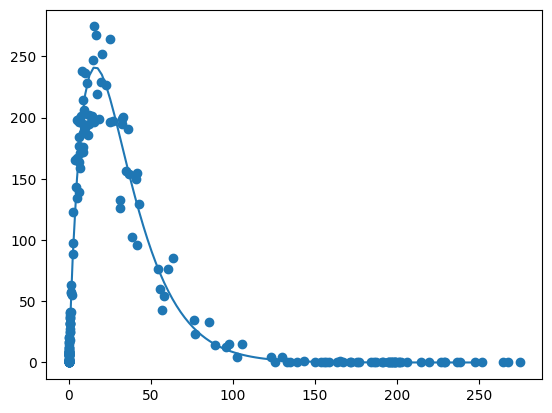

In [ ]:
f = RickerFunction()

n = np.linspace(0, 250, 100)
data = make_samples(1, 200, f, f.max_val, noise=0.25)

plt.plot(n, f(n))
plt.scatter(data[:-1], data[1:])

Best regression result:
Spline Transformer with Ridge Regression

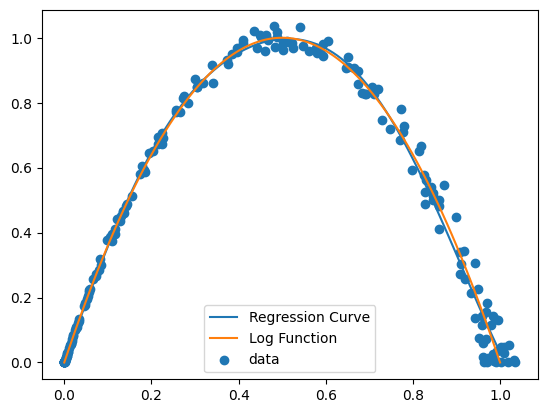

In [ ]:
g = LogisticFunction()

# Chaos in the logistic function does not really like noise
log_data = make_samples(1, 200, g, g.max_val, noise=0.05, limit=True)
x = log_data[:-1]
y = log_data[1:]

X_train = x[:, None]
y_train = y[:, None]
model = make_pipeline(SplineTransformer(n_knots=5, degree=10,knots="quantile"), Ridge(alpha=1e-2 ))
model.fit(X_train, y_train)

n = np.linspace(0, 1, 100)
plt.plot(n, model.predict(n[:,None]), label="Regression Curve")
plt.plot(n, g(n), label="Log Function")
plt.scatter(X_train, y_train, label="data")
plt.legend()

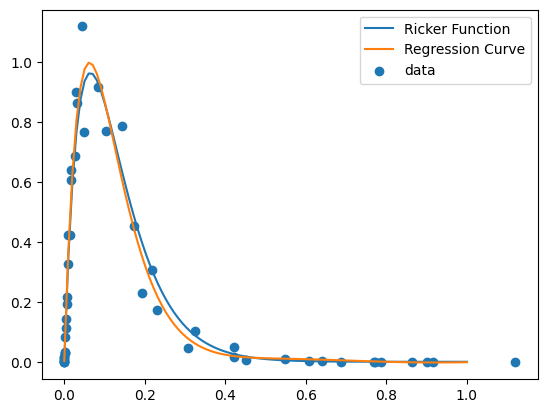

In [ ]:
data = make_samples(1, 50, f, f.max_val, noise=0.25)
x = data[:-1] / 250
y = data[1:] / 250

X_train = x[:, None]
y_train = y[:, None]
model = make_pipeline(SplineTransformer(n_knots=5, degree=10,knots="quantile"), Ridge(alpha=1e-2 ))
model.fit(X_train, y_train)

n = np.linspace(0, 1, 100)
plt.plot(n, f(n*250) / 250, label="Ricker Function")
plt.plot(n, model.predict(n[:,None]), label="Regression Curve")

plt.scatter(X_train, y_train, label="data")
plt.legend()

### Graph Construction

### Sampling Based All-in-One Approach



In [ ]:
def plot_partition(i, j, min_val, max_val, f=None, e=None, Edge=None, save=False):
  """ Function to visualize the curve walking
  """
  # Area of interest
  if not e is None:
      plt.gca().add_patch(Rectangle((i*e, j*e), e,e, alpha=0.3, color="r"))
  n = np.linspace(min_val, max_val, 200)
  plt.plot(n, f(n), label="Ricker")
  plt.legend()
  plt.xlim(min_val, max_val)
  plt.ylim(min_val, max_val)

  if Edge is None:
      pass
  elif Edge:
      plt.title(f"Partition i={i} and j={j} with edge in G_f")
  else:
      plt.title(f"Partition i={i} and j={j} with no edge in G_f")

  if save:
      filename = f'plot_{i}_{j}.png'
      plt.savefig(filename)
      filenames.append(filename)
      plt.close()

  plt.show()

In [ ]:
class GraphConstructor:

    def __init__(self, n_partitions, x=None, y=None, f=None, min_val=None, max_val=None, automatic_padding="None", verbose=False):
        """ Initializes the first adjacency matrix with the first datapoints
        Args:
          x: Array containing the x value of the datapoints
          y: Array containing the y value of the datapoints
          n_partitions: Number of equally spaces partitions beween min and max
          min: Minimal partition edge
          max: Maximal partition edge
          automatic_padding: ["max"]Add more rows and collumns in case new data exceeds the current min/max edges
        """
        self.N = n_partitions
        self.verbose = verbose

        # Initialize cumulated adjacency matrix and node edge counter
        self.CA = dok((n_partitions, n_partitions), dtype=int) # Using Sparse Matrix format
        # Regression Matrix, gets initialized as dok
        self.RM = None
        # Transition values, gets initialized as dok
        self.TVals = None
        self.G = None
        self.slope = None
        self.edge_cntr = np.zeros(n_partitions)

        # Convert parameter to bool
        if automatic_padding == "max":
          self.max_padding = True
        else:
          self.max_padding = False

        # Preset in case not specified
        self.x = np.array([])
        self.y = np.array([])
        self.function = None

        # if function is specified
        if not f is None:
            self.function = f
            # gets overritten if x and y are specified
            self.min = min_val
            self.max = max_val

            # Set partition size
            self.e = (self.max - self.min) / self.N

        if not(x is None or y is None):
            # Set min and max values
            if min_val is None:
                self.min = min(min(x), min(y)) - 1e-10
            else:
                self.min = min_val

            if max_val is None:
                self.max = max(max(x), max(y)) + 1e-10
            else:
                self.max = max_val

            self.x = x
            self.y = y

            # Set partition size
            self.e = (self.max - self.min) / self.N

            # Fill first matrix
            self.update(x, y)


    def _Af(self, i,j):
        """ Tests whether there is an edge between two nodes using a function
        Args:
          i: node 1 (N_t) (X)
          j: node 2 (N_t+1) (Y)
        """
        f_i0 = self._f(i*self.e)
        f_i1 = self._f((i+1)*self.e)

        # In the partition when f is increasing between j*e and (j+1)*e
        if (f_i0 <= f_i1 and f_i0 <=(j+1)*self.e and f_i1 >=j*self.e):
            return 1
        # In the partition when f is decreasing between (j+1)*e and j*e
        if (f_i0 >= f_i1 and f_i0 >=j*self.e and f_i1 <=(j+1)*self.e):
            return 1

        return 0


    def _splineReg(self, x, y, n_knots=5, degree=10, alpha=1e-2, **kwargs):
        """ Fits a spline regression
        Args:
          x, y: as in __init__
          degree: degree of the regression
        """
        self.model = make_pipeline(SplineTransformer(n_knots=n_knots, degree=degree, knots="quantile"), Ridge(alpha=alpha))
        self.model.fit(self._arrayNorm(x), self._arrayNorm(y))

    def _f(self, x):
        """ Performs the regression with data transformation for the first construction.
        Args:
          x: Single Value

        Returns:
          Prediction from the model for x unnormalized. Values stay between self.min and self.max
        """
        if self.function is None:
            return np.clip(self._renorm(self.model.predict(self._norm(x))), self.min, self.max)
        else:
            return self.function(x)

    def f(self, x, clip=True):
        if self.function is None:
            if clip:
                return np.clip(self._renorm(self.model.predict(self._arrayNorm(x))), self.min, self.max)
            return self._renorm(self.model.predict(self._arrayNorm(x)))
        else:
            return self.function(x)

    def _arrayNorm(self, vals):
        """ Normalizes an Array for the regression
        Args:
          vals: Numpy array

        Returns:
          Normalized vals array with the shape (len(vals), 1)
        """
        return np.reshape((vals - self.min) / (self.max - self.min), (len(vals), 1))

    def _norm(self, val):
        """ Normalizes a single value for the construction
        Args:
          val: Single Numeric value

        Returns:
          Normalized value as an two dimensional array with a single element
        """
        return np.reshape((val - self.min) / (self.max - self.min), (1, 1))

    def _renorm(self, val):
        """ Transforms normalized values b
        Args:
          val: Either array or single element
        """
        return np.squeeze(val * (self.max - self.min) + self.min)


    def _construct(self, probs_r=-1, **kwargs):
        """ Constructs an adjacency matrix by following a given curve
        Args:
          probs_r: [-1, 0<=] Range of the neighborhood to take into account for
                   calculating the probabilies or use no probabilies (-1)
          **kwargs: Arguments for the spline regression
        """

        # Separate Matrix for regression
        self.RM = dok((self.N, self.N), dtype=float)

        # Create regression curve for traversion if no function is specified
        if self.function is None:
            self._splineReg(self.x, self.y, kwargs=kwargs)

        # Initialize wandering
        col = int(self.min // self.e)
        row = int(self._f(self.min) // self.e)
        if probs_r >= 0:
          self.RM[row, col] = self._get_probs_vicinity(row, col, probs_r)
        else:
          self.RM[row, col] = 1

        # Save previous column
        prev_row = 0
        # Stores wheter graph is rising of falling
        sign_slope = 1
        self.slope = np.zeros(self.N)

        while True:
            # Go up
            if (prev_row != row + 1) & (row + 1 < self.N) & self._Af(col, row + 1):
                prev_row = row
                row += 1
                # Graph has positive slope
                sign_slope = 0

            # Go down
            elif (prev_row != row - 1) & (row > 0) & self._Af(col, row - 1):
                prev_row = row
                row -= 1
                # Graph has negative slope
                sign_slope = 1

            # Go right
            elif (col + 1 < self.N) & self._Af(col + 1, row):
                # save the slope for the current row
                self.slope[col] = sign_slope
                prev_row = row
                col += 1

            # In Case the function is not continous
            else:
                break

            # Set value in matrix
            if probs_r >= 0:
                self.RM[col, row] = self._get_probs_vicinity(row, col, probs_r)
            else:
                self.RM[col, row] = 1

            if self.verbose:
                plot_partition(col, row, self.min, self.max, self.f, self.e, 1)

    def _get_probs_vicinity(self, row, col, r=1):
        """Calculates the empirical probabilities of reaching a point in the vicinity of the actual point
        Args:
          row: N_t
          col: N_t+1
          r: What value range in the neighborhood is taken into account for
        """
        # Calculate how many neighbors are in the specific range
        r_ind = int(r // self.e)

        # Sum up the values in the specified vicinity
        vic_cnt = self.CA[[row],np.arange(max(0,col-r_ind), min(col+1+r_ind, self.N-1))].sum()

        if vic_cnt != 0:
            # Calculate probability
            return vic_cnt / self.edge_cntr[row]

        # If no values in vicinity nothing can be derived, thus prob is 1
        return 1


    def _updateSingle(self, x, y):
        """ Function that uptates the cumulated adjacency matrix with one x-y-pair
        Args:
          x: Single Value
          y: Single Value
        """

        # Forces lower bounds
        x = max(self.min, x)
        y = max(self.min, y)

        # Tests if the values exceed the maximal matrix boundaries
        # Pads the matrix if wanted, otherwise limit inputs
        if ((self.max < x ) or (self.max < y)):
            if self.max_padding:
                max_val = max(x,y)
                pad = int((max_val - self.min) // self.e + 1)
                self.CA.resize((pad, pad))
                self.edge_cntr.resize(pad)
                self.N = pad
                self.max = max_val + 1e-10
            else:
                x = min(self.max-1e-10, x)
                y = min(self.max-1e-10, y)

        # Get Row and Column
        row = int((x - self.min) // self.e)
        col = int((y - self.min) // self.e)

        # Incremenet partition
        self.CA[row, col] += 1
        # Increment node edge counter
        self.edge_cntr[row] += 1


    def update(self, x, y):
        """ Update the cumulated adjacency matrix with new edges for each x-y-pair
        Args:
          x: Single Value or array containing new x values
          y: Single Value or array containing new y values
          update_RM: Whether to also update the entries of the regression matrix if it
                     was already created

        Returns:
          A: The cumulated adjacency matrix
        """

        # If inputs are single numbers
        if isinstance(x, numbers.Number):
            self._updateSingle(x, y)

            # Add the samples to the the data
            self.x = np.concatenate([self.x, [x]])
            self.y = np.concatenate([self.y, [y]])
            return self.CA.copy()

        # If inputs are arrays
        x = x.squeeze()
        y = y.squeeze()

        # iterate over each x-y-pair
        for i in range(len(x)):

            self._updateSingle(x[i], y[i])

        self.x = np.concatenate([self.x, x])
        self.y = np.concatenate([self.y, y])
        return self.CA.copy()


    def get_node(self, y):
        """ Returns the node number for a given value
        Args:
          y: Value for which to get the node number
        """
        y = (np.clip(y, self.min, self.max) - self.min) // self.e

        if isinstance(y, np.ndarray):
            return y.astype(int)
        else:
            return int(y)


    def get_cumulated_adjacency(self, density=True):
        """ Returns the adajacency matrix retrieved from the samples
        Args:
          density: Whether to return desities or absolut counts
        """

        if density:
            return (self.CA.T / np.where(self.edge_cntr != 0, self.edge_cntr, 1)).T.copy()
        else:
            return self.CA.copy()


    def get_regression_matrix(self, probs_r=-1, force_new=False, **kwargs):
        """ Returns the regression matrix
        Args:
          probs_r: [-1, 0<=] Range of the neighborhood to take into account for
                   calculating the probabilies or use no probabilies (-1)
          force_new: Whether to calculate the regression anew even though it already exists
        """

        if self.RM is None or force_new:
            self._construct(probs_r=probs_r, kwargs=kwargs)

        return self.RM.copy()


    def set_f(self, function=None):
        """ Set a function that will than be used in the construction or set no function. Than the interpolation is used
        Args:
          function: Callable function that fits the data
        """
        if callable(function) or function is None:
            self.function = function


    def create_graph(self, probs_r=-1, force_new=False, **kwargs):
        """ Creates Graph and saves it in the object
        Args:
          probs_r: [-1, 0<=] Range of the neighborhood to take into account for
                   calculating the probabilies or use no probabilies (-1)
          force_new: Whether to calculate the regression anew even though it already exists
        """

        if self.G is None or force_new:
            # If regression matrix has not been created jet
            if self.RM is None or force_new:
                self._construct(probs_r=probs_r, kwargs=kwargs)

            # Create Graph from regression Matrix
            self.G = nx.DiGraph(self.RM.toarray())

        return self.G



In [ ]:
data = make_samples(1, 1000, f, f.max_val, noise=0.25)
gConst= GraphConstructor(200, x=data[:-1], y=data[1:], min_val=0, max_val=250, automatic_padding="max", verbose=False)
rm = gConst.get_regression_matrix(-1, force_new=True)
G = gConst.create_graph()

#### Graph and plot together

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

# Show Plot of Regression
n = np.linspace(0, gConst.max, gConst.N)
ax1.set_xticks(n, np.arange(gConst.N), horizontalalignment="left", rotation=90)
ax1.set_yticks(n, np.arange(gConst.N))
ax1.grid()
ax1.plot(np.arange(280), f(np.arange(280)), label="Actual Function")
ax1.plot(np.arange(280), gConst.f(np.arange(280)), label="Interpolation")

ax1.legend()
ax1.set_xlim(0)
ax1.set_ylim(0)

# Draw Graph
nx.draw(G, pos=nx.circular_layout(G), ax=ax2, with_labels=True)

#### Comparison

In [ ]:
import time, timeit

In [ ]:
def Af(f,i,j,e):
        """ Tests whether there is an edge between two nodes using a function
        Args:
          i: node 1 (N_t) (X)
          j: node 2 (N_t+1) (Y)
        """
        f_i0 = f(i*e)
        f_i1 = f((i+1)*e)

        # In the partition when f is increasing between j*e and (j+1)*e
        if (f_i0 <= f_i1 and f_i0 <=(j+1)*e and f_i1 > j*e):
            return 1
        # In the partition when f is decreasing between (j+1)*e and j*e
        if (f_i0 >= f_i1 and f_i0 > j*e and f_i1 <=(j+1)*e):
            return 1

        return 0

##### Naive

In [ ]:
def naive_construction(f, N, min_val, max_val):

    e = (max_val - min_val) / N
    adj = dok((N, N), bool)
    cnt = 0

    for i in range(N):
        for j in range(N):
            cnt += 1
            if Af(f, i, j, e):
                adj[i, j] = True

    return adj, cnt

##### Naive + Pruning

In [ ]:
def pruning_construction(f, N, min_val, max_val):

    e = (max_val - min_val) / N
    adj = dok((N, N), bool)
    cnt = 0

    for i in range(N):
        flag = False
        for j in range(N):
            cnt += 1
            if Af(f, i, j, e):
                adj[i, j] = True
                flag = True

            elif flag:
                break

    return adj, cnt

##### Graph walking (bare)

In [ ]:
def walking_construction(f, N, min_val, max_val):

    e = (max_val - min_val) / N
    adj = dok((N, N), bool)
    cnt = 0

    i = 0
    j = 0
    adj[i, j] = True

    prev_i = 0

    while True:

        if (prev_i != i + 1) & (i + 1 < N) & Af(f, j, i + 1, e):
            prev_i = i
            i += 1
            cnt += 1

        elif (prev_i != i - 1) & (i > 0) & Af(f, j, i - 1, e):
            prev_i = i
            i -= 1
            cnt += 1

        elif (j + 1 < N) & Af(f, j + 1, i, e):
            prev_i = i
            j += 1
            cnt += 2

        else:
            cnt += 3
            break

        adj[j, i] = True

    return adj, cnt


##### Runntimes Ricker function

In [ ]:
Ns = [20, 50, 100, 1000, 2000, 3000, 4000, 5000]
ts = np.zeros((3, len(Ns)))
cnts = np.zeros((3, len(Ns)))
adjs_naive = {}
adjs_prune = {}
adjs_walk = {}

for i, N in enumerate(Ns):
  start = time.time()
  adjs_naive[N], cnts[0, i] = naive_construction(f, N, 0, 242)
  end = time.time()
  ts[0,i] = end - start

  start = time.time()
  adjs_prune[N], cnts[1, i] = pruning_construction(f, N, 0, 242)
  end = time.time()
  ts[1,i] = end - start

  start = time.time()
  adjs_walk[N], cnts[2, i] = walking_construction(f, N, 0, 242)
  end = time.time()
  ts[2,i] = end - start

Text(4075, 8000000.0, '25,000,000')

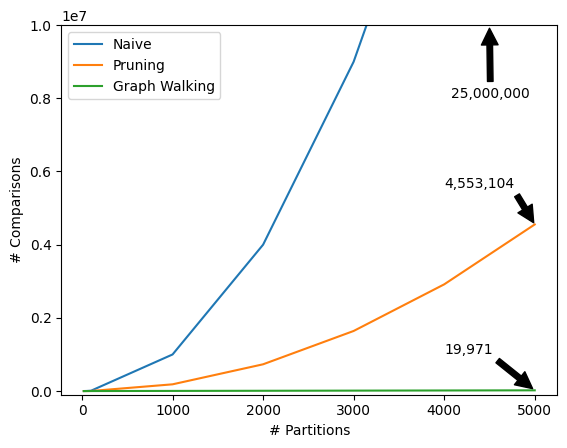

In [ ]:
plt.plot(Ns, cnts.T, label=["Naive", "Pruning", "Graph Walking"])
plt.ylim(-1e5,1e7)
plt.legend(loc="upper left")
plt.ylabel("# Comparisons")
plt.xlabel("# Partitions")
plt.annotate(f"{int(cnts[2,-1]):,}", xy=(Ns[-1], cnts[2,-1]), xytext=(Ns[-1] - 1000, cnts[2,-1] + 1e6),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.annotate(f"{int(cnts[1,-1]):,}", xy=(Ns[-1], cnts[1,-1]), xytext=(Ns[-1] - 1000, cnts[1,-1] + 1e6),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.annotate(f"{int(cnts[0,-1]):,}", xy=(Ns[-1] - 500, 1e7), xytext=(Ns[-1] - 925, 1e7 - 2e6),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

Text(4000, 88.4334659576416, '88.9335')

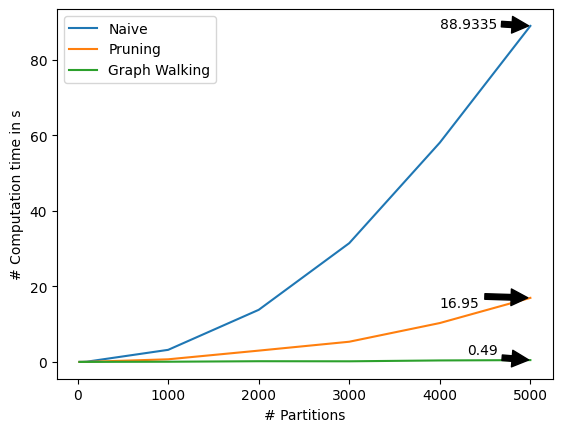

In [ ]:
plt.plot(Ns, ts.T, label=["Naive", "Pruning", "Graph Walking"])

plt.legend(loc="upper left")
plt.ylabel("# Computation time in s")
plt.xlabel("# Partitions")
plt.annotate(f"{ts[2,-1]:.2f}", xy=(Ns[-1], ts[2,-1]), xytext=(Ns[-1]-700, 2),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.annotate(f"{ts[1,-1]:.2f}", xy=(Ns[-1], ts[1,-1]), xytext=(Ns[-1]-1000, ts[1,-1]-2.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.annotate(f"{ts[0,-1]:.4f}", xy=(Ns[-1], ts[0,-1]), xytext=(Ns[-1]-1000, ts[0,-1]-0.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

In [ ]:
if (~(adjs_naive[20] != adjs_prune[20]).toarray()).all() and (~(adjs_naive[20] != adjs_walk[20]).toarray()).all():
    print("The three adjacency matrices are the same")

The three adjacency matrices are the same


##### Runtimes logistic function

In [ ]:
Ns = [20, 50, 100, 1000, 2000, 3000, 4000, 5000]
ts = np.zeros((3, len(Ns)))
cnts = np.zeros((3, len(Ns)))
adjs_naive = {}
adjs_prune = {}
adjs_walk = {}

for i, N in enumerate(Ns):
  start = time.time()
  adjs_naive[N], cnts[0, i] = naive_construction(g, N, 0, 1)
  end = time.time()
  ts[0,i] = end - start

  start = time.time()
  adjs_prune[N], cnts[1, i] = pruning_construction(g, N, 0, 1)
  end = time.time()
  ts[1,i] = end - start

  start = time.time()
  adjs_walk[N], cnts[2, i] = walking_construction(g, N, 0, 1)
  end = time.time()
  ts[2,i] = end - start

Text(4075, 8000000.0, '25,000,000 &\n   16,679,051')

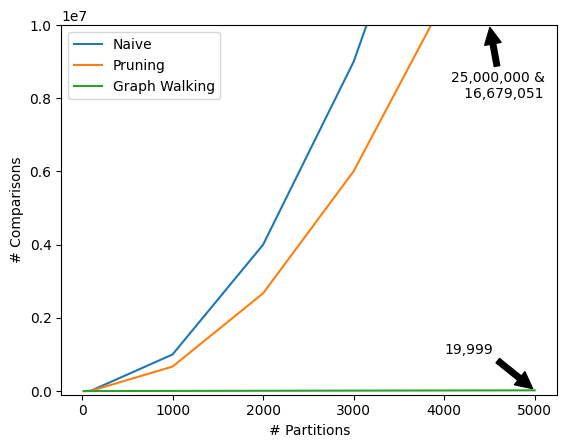

In [ ]:
plt.plot(Ns, cnts.T, label=["Naive", "Pruning", "Graph Walking"])
plt.ylim(-1e5,1e7)
plt.legend(loc="upper left")
plt.ylabel("# Comparisons")
plt.xlabel("# Partitions")
plt.annotate(f"{int(cnts[2,-1]):,}", xy=(Ns[-1], cnts[2,-1]), xytext=(Ns[-1] - 1000, cnts[2,-1] + 1e6),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.annotate(f"{int(cnts[0,-1]):,} &\n   {int(cnts[1,-1]):,}", xy=(Ns[-1] - 500, 1e7), xytext=(Ns[-1] - 925, 1e7 - 2e6),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

In [ ]:
if (~(adjs_naive[5000] != adjs_prune[5000]).toarray()).all() and (~(adjs_naive[5000] != adjs_walk[5000]).toarray()).all():
    print("The three adjacency matrices are the same.")

The three adjacency matrices are the same.


##### Comparison & runtime curve walking

In [ ]:
Ns = np.linspace(20, 20000, 100, dtype=int)
ts = np.zeros(100)
cnts = np.zeros(100)

for i, N in enumerate(Ns):
    start = time.time()
    _, cnts[i] = walking_construction(f, N, 0, 242)
    end = time.time()
    ts[i] = end - start

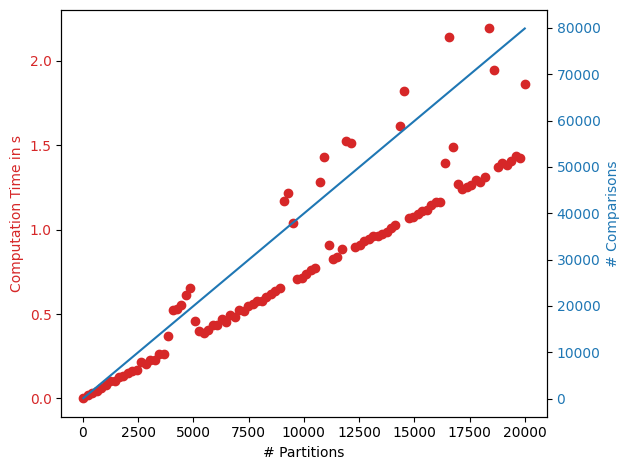

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('# Partitions')
ax1.set_ylabel('Computation Time in s', color=color)
ax1.scatter(Ns, ts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('# Comparisons', color=color)  # we already handled the x-label with ax1
ax2.plot(Ns, cnts, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


#### Intervention Functions

In [ ]:
class Interventor:

    def __init__(self, GraphConst, target_val, max_intervention=np.inf, verbose=False):
        """ Initializes the attributes, tests requirements and prepares intervention
        Args:
          GraphConst: GraphConstructor object were intervention is wanted
          source_val: Start value before the intervention
          target_val: Target value which is supposed to be reached after the interventions
          max_intervention: Maximal absolut intervention, must be bigger or equal to GraphConst.e
          inv_cost_func: Function that assignes costs to interventions, suggested is exponential function
        """

        # Initialize
        self.gCon = GraphConst
        self.t = target_val
        self.verbose = verbose
        if max_intervention < self.gCon.e:
            print(f"Warning: Maximal intervention smaller than e!\nMaximal Intervention has been set to e = {GraphConst.e}.")
            self.max_int = self.gCon.e
        else:
            self.max_int = max_intervention

        # Get target node
        self.t_node = GraphConst.get_node(target_val)

        # Reverse the graphs edges to find paths towards the target node
        if GraphConst.G is None:
            self.G_rev = GraphConst.create_graph().reverse()
        else:
            self.G_rev = GraphConst.G.reverse()

        # Calculate all paths towards the target node
        # This reduces computation costs as the changes to the
        # planned path only need a lookup in the dictionary
        # Also, paths are already reversed
        self.node_paths = nx.single_source_dijkstra_path(self.G_rev, self.t_node, weight="None")

        # If there is only one path in the reverse path that means that it has no incomming
        # edges in the actual graph and is therefore not reachable
        if len(self.node_paths) == 1:
            print("Target value not reachable!")

        # Save taken paths and values
        self.nodes = []
        self.values = []
        self.interventions = []

        # flag if target has been reached
        self.reached = False

        # step counter
        self.steps = 0

    def intervention(self, x):
        """ Calculates intervention for one step based on the given value which
            is expected to be the next value from the current node

        """

        int_val = 0

        # increase step number
        self.steps += 1

        self.current_node = self.gCon.get_node(x)
        print("Current node: ", self.current_node)

        # if target is near by
        if not self.reached and self.current_node == self.t_node:
            int_val = self.t - x
            self.reached = True

            # Save values to past path
            self.nodes.append(self.current_node)
            self.values.append(x)
            self.interventions.append(int_val)
            print(f"Target reached using {self.steps} steps")
            self.steps = 0
            return int_val

        # if the target has been reached and x is near a value we already had, intervene
        # to the already known value and from there on in the known way
        if self.reached and self.current_node in self.nodes:

            # if value has been reached before
            if x in self.values:
                # use known intervention
                idx = self.values.index(x)
                print("Using previous path.")
                return self.interventions[idx]

            print("Node already visited")
            idx = self.nodes.index(self.current_node)
            int_val = self.values[idx] + self.interventions[idx] - x

            # Save values to past path
            self.nodes.append(self.current_node)
            self.values.append(x)
            self.interventions.append(int_val)

            return int_val



        # Save values to past path
        self.nodes.append(self.current_node)
        self.values.append(x)

        # Include neighbors
        min_node = min(self.current_node, self.gCon.get_node(x - self.max_int) + 1)
        max_node = max(self.current_node, self.gCon.get_node(x + self.max_int) - 1)

        # fing neighbor with shortest path to target node
        nbrs = np.arange(min_node, max_node + 1)
        path_lengths = list(map(lambda x: len(self.node_paths[x]), nbrs))

        # Use neighbor node only if path length is shorter
        if min(path_lengths) < len(self.node_paths[self.current_node]):
            best_node = nbrs[np.argmin(path_lengths)]

            # intervention to go to the lower boundary of the best node
            int_val = best_node * self.gCon.e - x
            print("Best node: ", best_node)
            # use the best node to calculate further intervention
            self.current_node = best_node
            # the lower boundary is now the new x
            x += int_val

            # Check again if new new current node is target node
            if self.current_node == self.t_node:
                int_val += self.t - x
                # Add intervention from original node
                self.interventions.append(int_val)

                # Add intervention from new node
                self.nodes.append(self.current_node)
                self.values.append(x)
                self.interventions.append(self.t-x)

                print(f"Target reached using {self.steps} steps")
                self.reached=True
                return int_val

        # Get next node in the path
        self.next_node = self.node_paths[self.current_node][-2]
        print("Shortest Path: ", self.node_paths[self.current_node])
        print(f"Expected Path Length: {len(self.node_paths[self.current_node])}")

        # Get number of successors of previous node
        outDeg = self.gCon.G.out_degree(self.current_node)

        # if the node has only one successor, set value to middle value of node
        if outDeg == 1:
            next_val = (self.current_node + 0.5) * self.gCon.e

        # Calculate the inverse of the node
        else:
            next_val = self._precise_approx(x, outDeg)


        # Intervention is the calculated value to reach the next node minus the current value
        int_val +=  next_val - x

        self.interventions.append(int_val)
        return int_val


    def _precise_approx(self, x, outDeg):
        """ Approximates inverse value more accurately
        Args:
          x: Current value
          outDeg: Outgoing degree of current node
        """
        i = 0
        m = 1

        min_node = min(self.gCon.G[self.current_node])
        # slope as 0 and 1
        slope1 = self.gCon.slope[self.current_node]
        # slope as 1 and -1
        slope2 = slope1 * 2 - 1

        linear_partition = (abs(slope1 * (outDeg - 1) - self.next_node + min_node) + 0.5) / outDeg

        next_val = (self.current_node + linear_partition) * self.gCon.e

        # Check the target node with the regression
        f_val = self.gCon.f(np.array([next_val]))
        f_node = self.gCon.get_node(f_val)


        # adapt until the next predicted node is the target node
        while f_node != self.next_node:

            next_val -= (self.next_node - f_node ) * slope2 * m * self.gCon.e / outDeg

            f_val = self.gCon.f(np.array([next_val]))
            f_node = self.gCon.get_node(f_val)



            # half the step size
            m /= 2
            i += 1

            if i == 5:
                break

        return next_val


    def update_target(self, t):
        """ Sets a new target
        Args:
          t: New value to reach with interventions
        """

        self.t = np.clip(t, gConst.min, gConst.max)

        # Get target node
        t_node = self.gCon.get_node(t)

        # Calculate new paths if necessary
        if t_node != self.t_node:
            self.t_node = t_node
            self.node_paths = nx.single_source_dijkstra_path(self.G_rev, self.t_node, weight="None")


            # If there is only one path in the reverse path that means that it has no incomming
            # edges in the actual graph and is therefore not reachable
            if len(self.node_paths) == 1:
                print("Target value not reachable!")

            else:
                self.values = []
                self.interventions = []
                self.nodes = []
                self.reached = False
                self.steps = 0

        else:
            self.reached = False
            self.steps = 0

        print(f"New target value {self.t} in node {self.t_node}")


#### Tests

##### Test 0

In [ ]:
t = 230
max_int = 5
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [ ]:
x = 29
for i in range(20):
    int_val = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    print("")

Current node:  23
Shortest Path:  [184, 9, 0, 149, 23]
Expected Path Length: 5
Intervention:  1.0892857142857117
Next value:  190.31168960659477

Current node:  152
Shortest Path:  [184, 9, 0, 152]
Expected Path Length: 4
Intervention:  0.3133103934052315
Next value:  0.06051281089857274

Current node:  0
Shortest Path:  [184, 9, 0]
Expected Path Length: 3
Intervention:  0.20511218910142726
Next value:  10.569262794434286

Current node:  8
Best node:  9
Shortest Path:  [184, 9]
Expected Path Length: 2
Intervention:  1.8265705388990465
Next value:  233.44597325534508

Current node:  186
Best node:  184
Target reached using 5 steps
Intervention:  -3.4459732553450806
Next value:  0.00643982428349221

Current node:  0
Node already visited
Intervention:  0.2591851757165078
Next value:  10.569262794434286

Current node:  8
Using previous path.
Intervention:  1.8265705388990465
Next value:  233.44597325534508

Current node:  186
Using previous path.
Intervention:  -3.4459732553450806
Next val

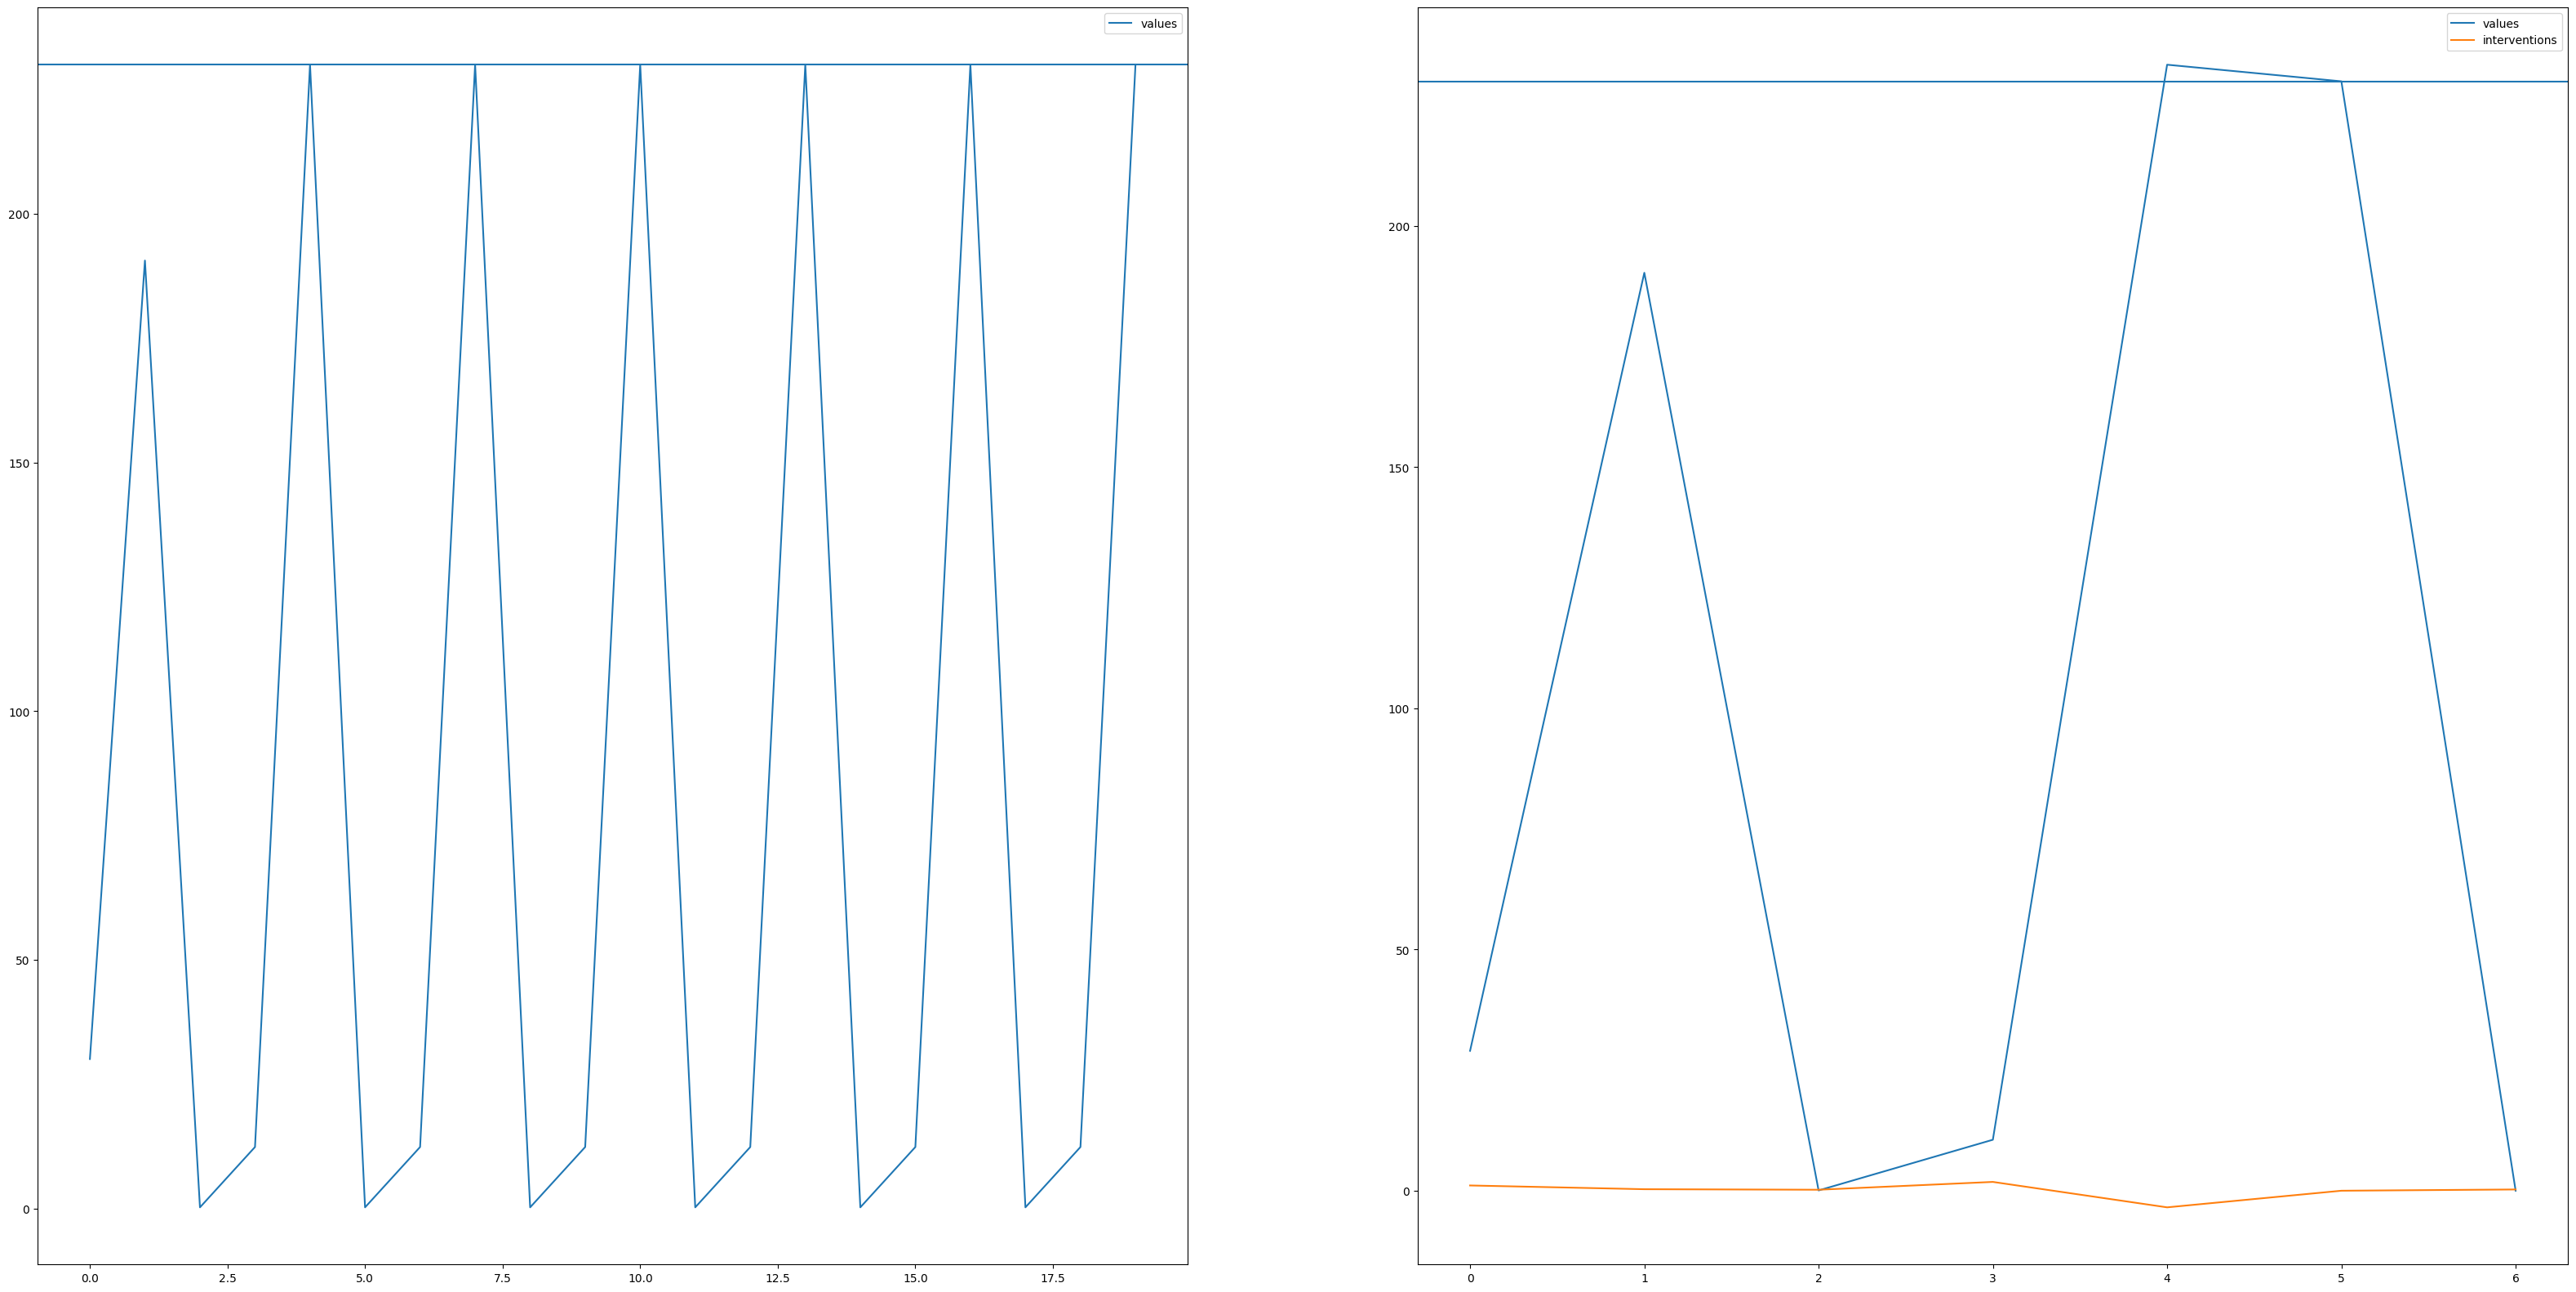

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t)
ax1.legend();

n = np.arange(len(testInt.values))
ax2.plot(n, testInt.values, label="values")
ax2.plot(n, testInt.interventions, label="interventions")
ax2.axhline(t)
ax2.legend();

##### Test 1 with Noise

In [ ]:
t = 130
max_int = 20
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [ ]:
x = 29
for i in range(20):
    int_val = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    x *= 1 + 0.1 * (random.rand()*1.5-0.75)
    print("Next value with noise: ", x)
    print("")

Current node:  23
Best node:  32
Shortest Path:  [104, 32]
Expected Path Length: 2
Intervention:  11.520833333333329
Next value:  134.69749992467516
Next value with noise:  140.9836390212519

Current node:  112
Best node:  104
Target reached using 2 steps
Intervention:  -10.98363902125189
Next value:  1.7347577595391763
Next value with noise:  1.7701350320188995

Current node:  1
Best node:  3
Shortest Path:  [104, 3]
Expected Path Length: 2
Intervention:  2.406001331617464
Next value:  130.56329065847186
Next value with noise:  128.37307264599295

Current node:  102
Best node:  104
Target reached using 4 steps
Intervention:  1.6269273540070515
Next value:  1.7347577595391763
Next value with noise:  1.7800688417419817

Current node:  1
Node already visited
Intervention:  2.3960675218943814
Next value:  130.56329065847186
Next value with noise:  125.86115126135638

Current node:  100
Best node:  104
Target reached using 6 steps
Intervention:  4.138848738643617
Next value:  1.73475775953

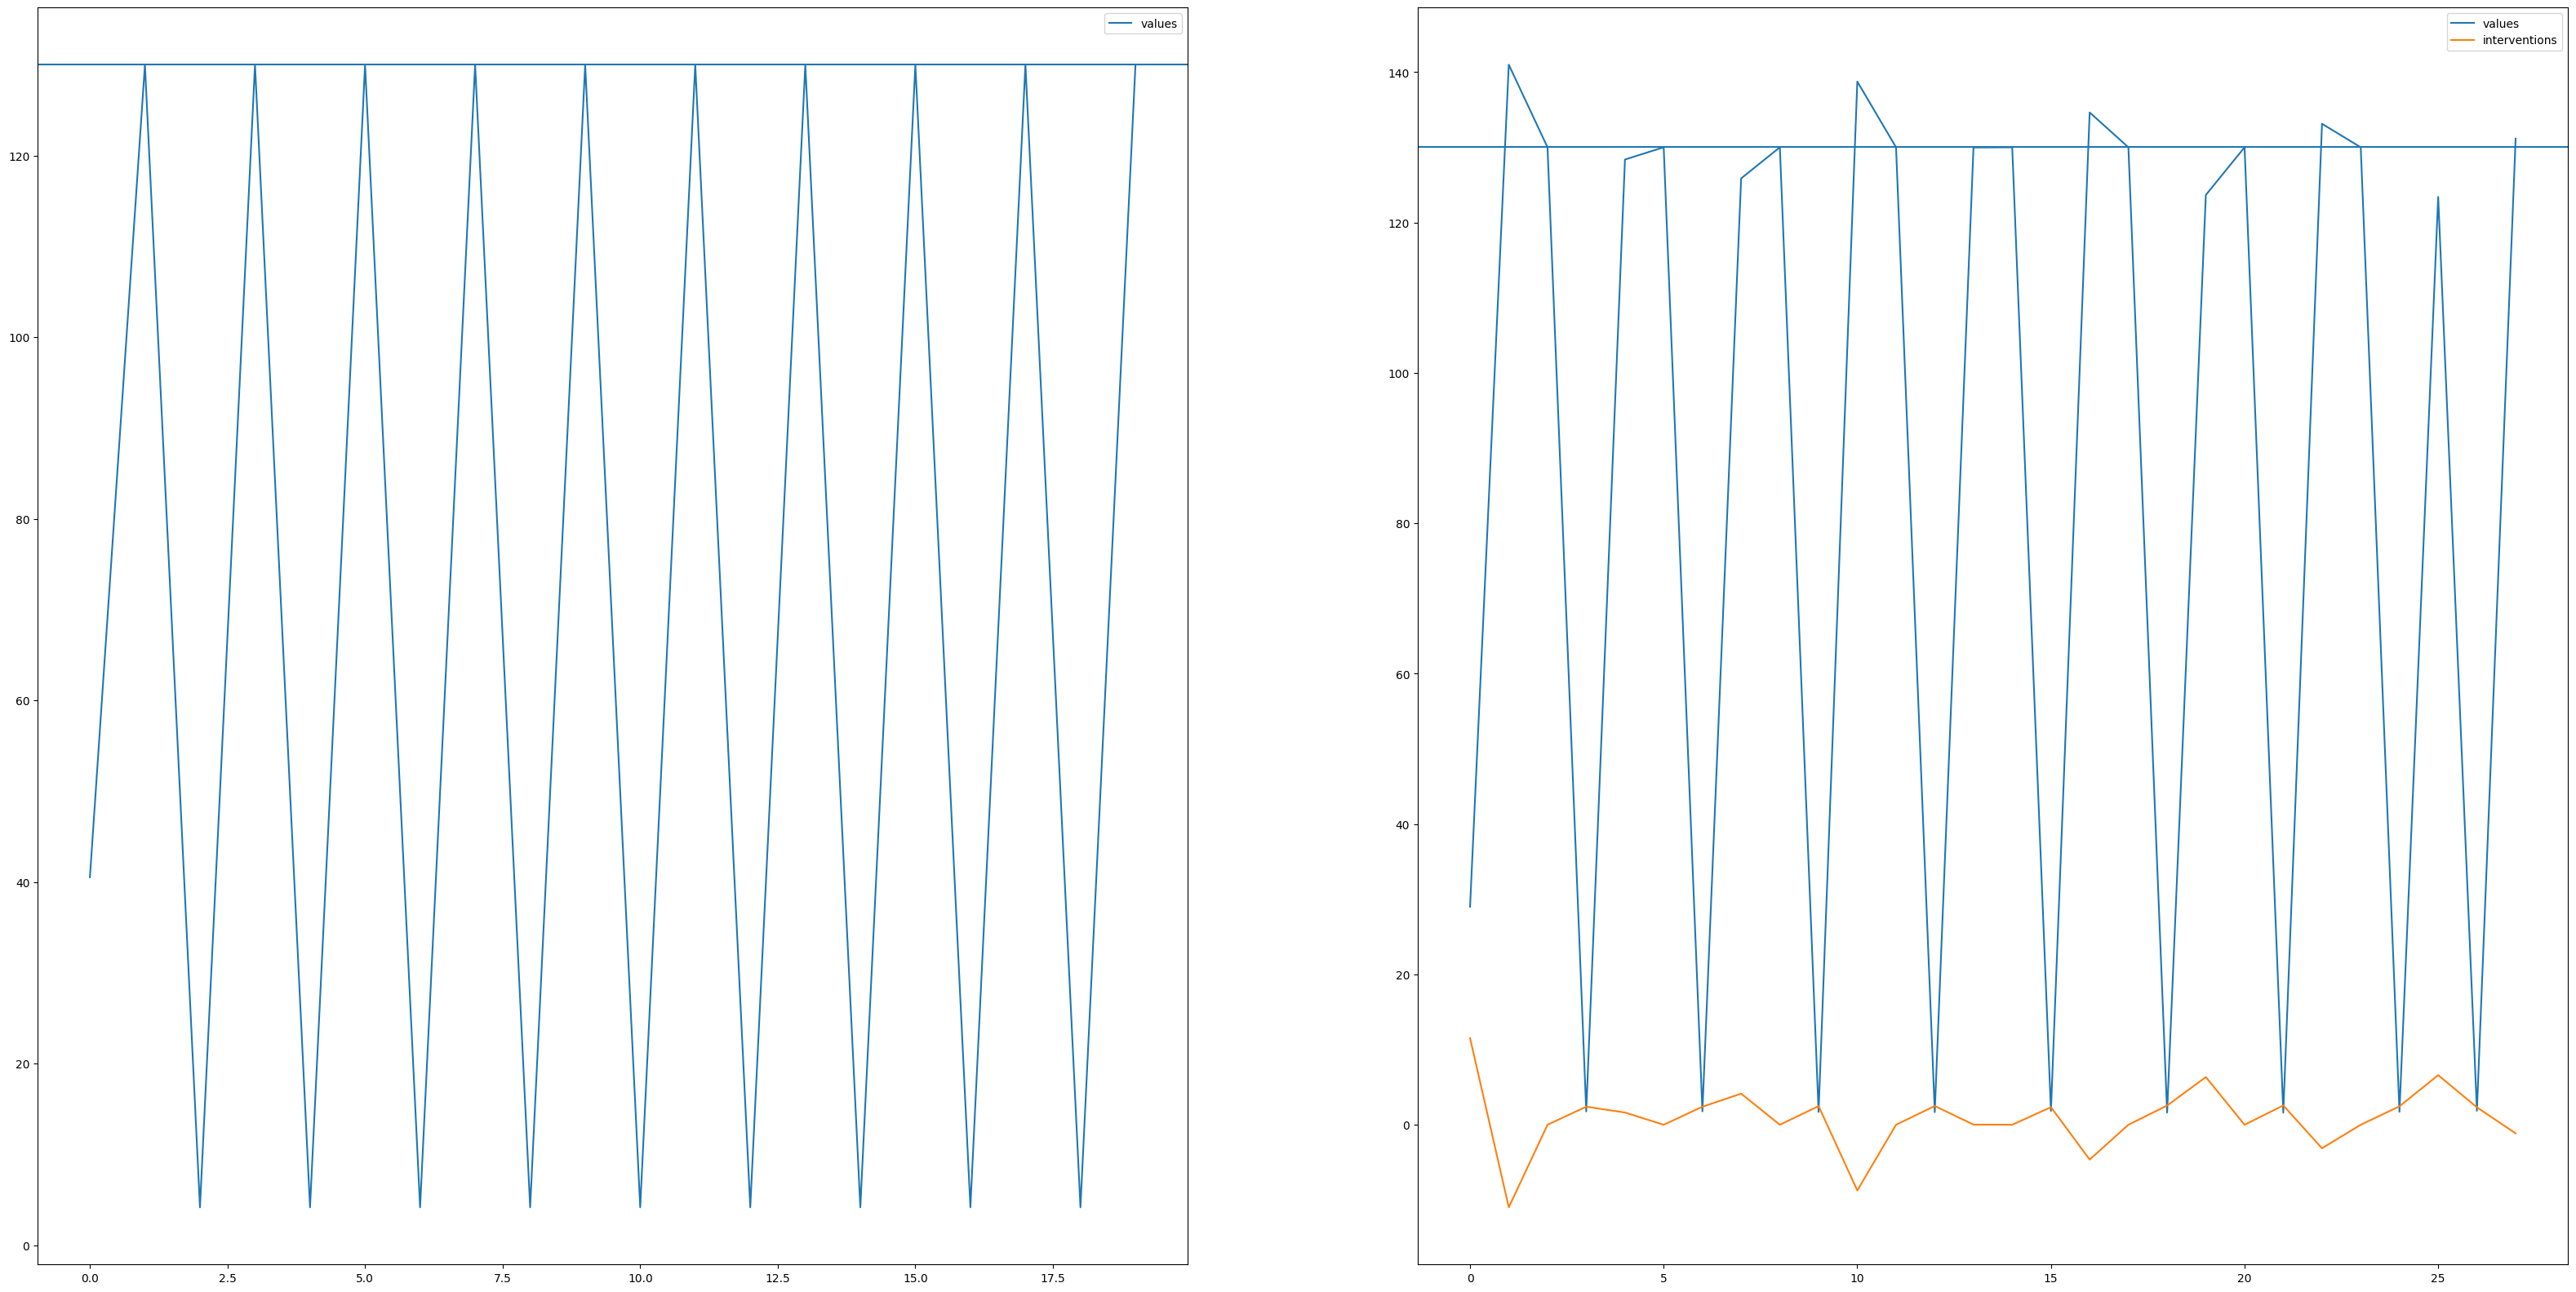

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t)
ax1.legend();

n = np.arange(len(testInt.values))
ax2.plot(n, testInt.values, label="values")
ax2.plot(n, testInt.interventions, label="interventions")
ax2.axhline(t)
ax2.legend();

##### Test 2

In [ ]:
t = 120
max_int = 5
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [ ]:
x = 29
for i in range(20):
    int_val = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    print("")

Current node:  23
Shortest Path:  [96, 2, 0, 149, 23]
Expected Path Length: 5
Intervention:  1.0892857142857117
Next value:  190.31168960659477

Current node:  152
Shortest Path:  [96, 2, 0, 152]
Expected Path Length: 4
Intervention:  0.3133103934052315
Next value:  0.06051281089857274

Current node:  0
Best node:  2
Shortest Path:  [96, 2]
Expected Path Length: 2
Intervention:  3.712635337249575
Next value:  120.93246344461629

Current node:  96
Target reached using 4 steps
Intervention:  -0.9324634446162889
Next value:  2.9668231764407267

Current node:  2
Shortest Path:  [96, 2]
Expected Path Length: 2
Intervention:  0.8063249717074212
Next value:  120.93246344461629

Current node:  96
Using previous path.
Intervention:  -0.9324634446162889
Next value:  2.9668231764407267

Current node:  2
Using previous path.
Intervention:  0.8063249717074212
Next value:  120.93246344461629

Current node:  96
Using previous path.
Intervention:  -0.9324634446162889
Next value:  2.9668231764407267

C

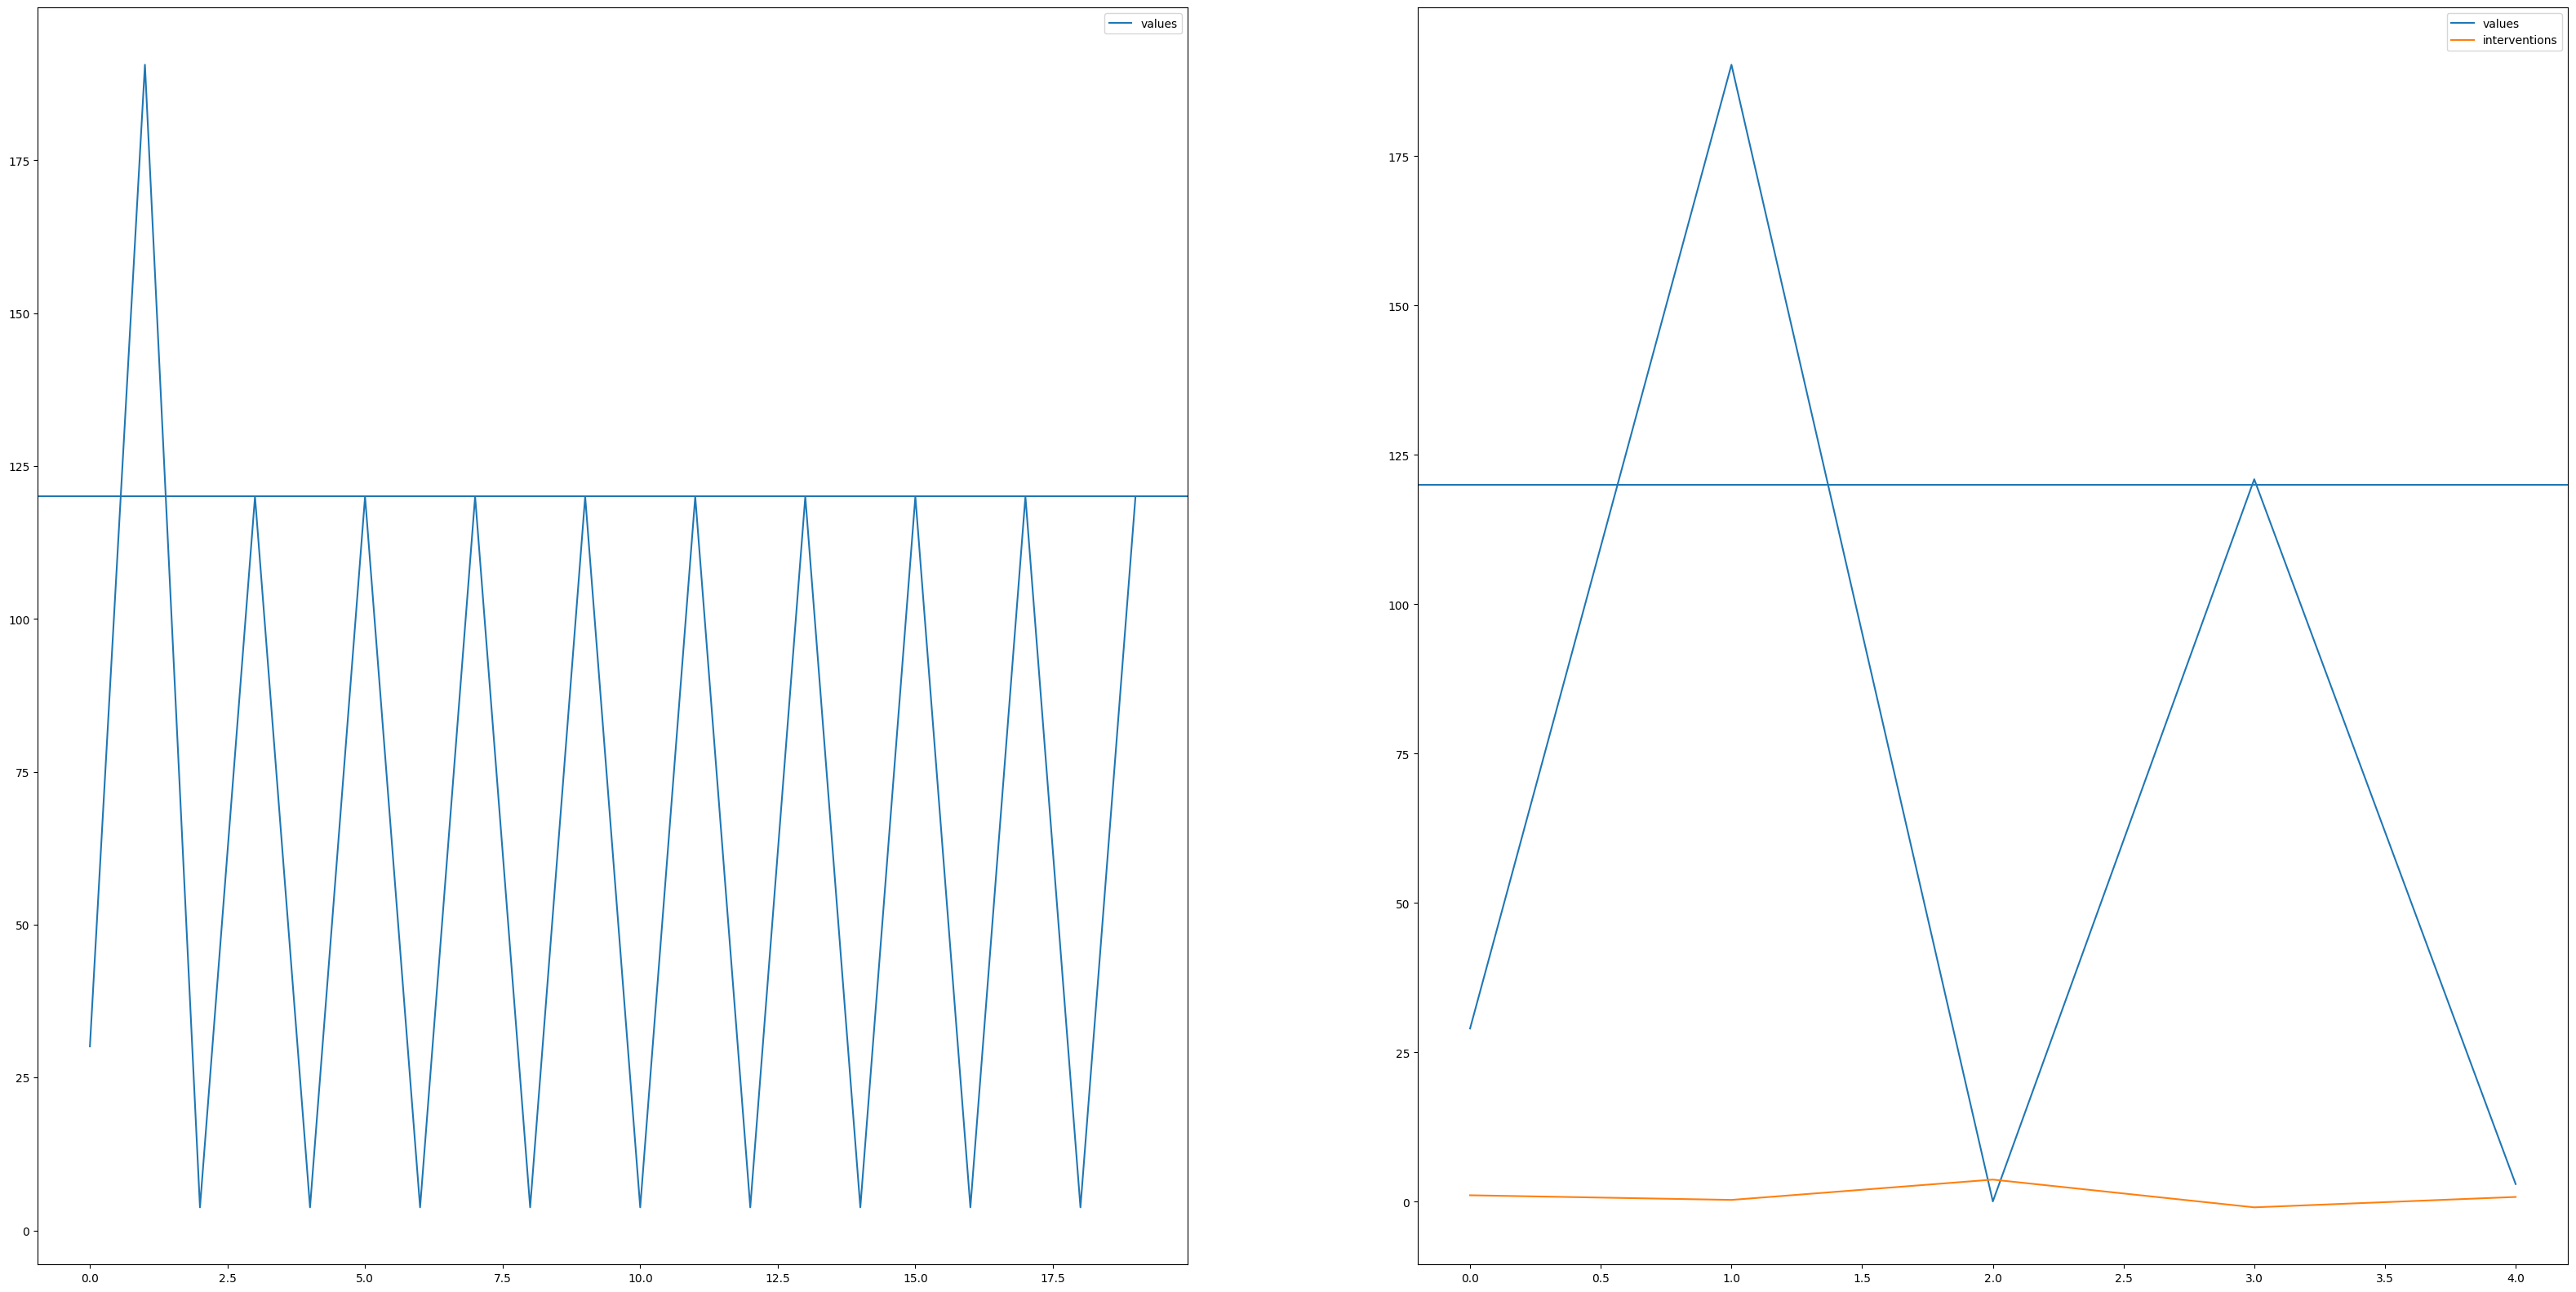

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

# # Show Plot of Regression
# n = np.linspace(0, gConst.max, gConst.N)
# ax1.set_xticks(n, np.arange(gConst.N), horizontalalignment="left", rotation=90)
# ax1.set_yticks(n, np.arange(gConst.N))
# ax1.grid()
# ax1.plot(np.arange(280), gConst.f(np.arange(280)), label="Regression")
# ax1.plot(np.arange(280), f(np.arange(280)), label="Ricker")
# ax1.set_xlim(0)
# ax1.set_ylim(0)
# ax1.legend()

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t)
ax1.legend();

n = np.arange(len(testInt.values))
ax2.plot(n, testInt.values, label="values")
ax2.plot(n, testInt.interventions, label="interventions")
ax2.axhline(t)
ax2.legend();

In [ ]:
n1 = len(all_vals)
t2 = 42
testInt.update_target(t2)

for i in range(20):
    int_val = testInt.intervention(x)
    all_vals.append(x+int_val)
    print("Intervention: ", int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    print("")

New target value 42.0 in node 33
Current node:  2
Best node:  1
Shortest Path:  [33, 53, 1]
Expected Path Length: 3
Intervention:  -1.1894794264407267
Next value:  64.42598914714299

Current node:  51
Best node:  53
Shortest Path:  [33, 53]
Expected Path Length: 2
Intervention:  3.2823441861903575
Next value:  42.092182819216376

Current node:  33
Target reached using 3 steps
Intervention:  -0.09218281921637583
Next value:  127.44305256629842

Current node:  101
Best node:  102
Shortest Path:  [33, 53, 1, 102]
Expected Path Length: 4
Intervention:  0.9944474337015805
Next value:  1.887267290408746

Current node:  1
Shortest Path:  [33, 53, 1]
Expected Path Length: 3
Intervention:  -0.10992354040874597
Next value:  64.42598914714299

Current node:  51
Using previous path.
Intervention:  3.2823441861903575
Next value:  42.092182819216376

Current node:  33
Using previous path.
Intervention:  -0.09218281921637583
Next value:  127.44305256629842

Current node:  101
Using previous path.
Int

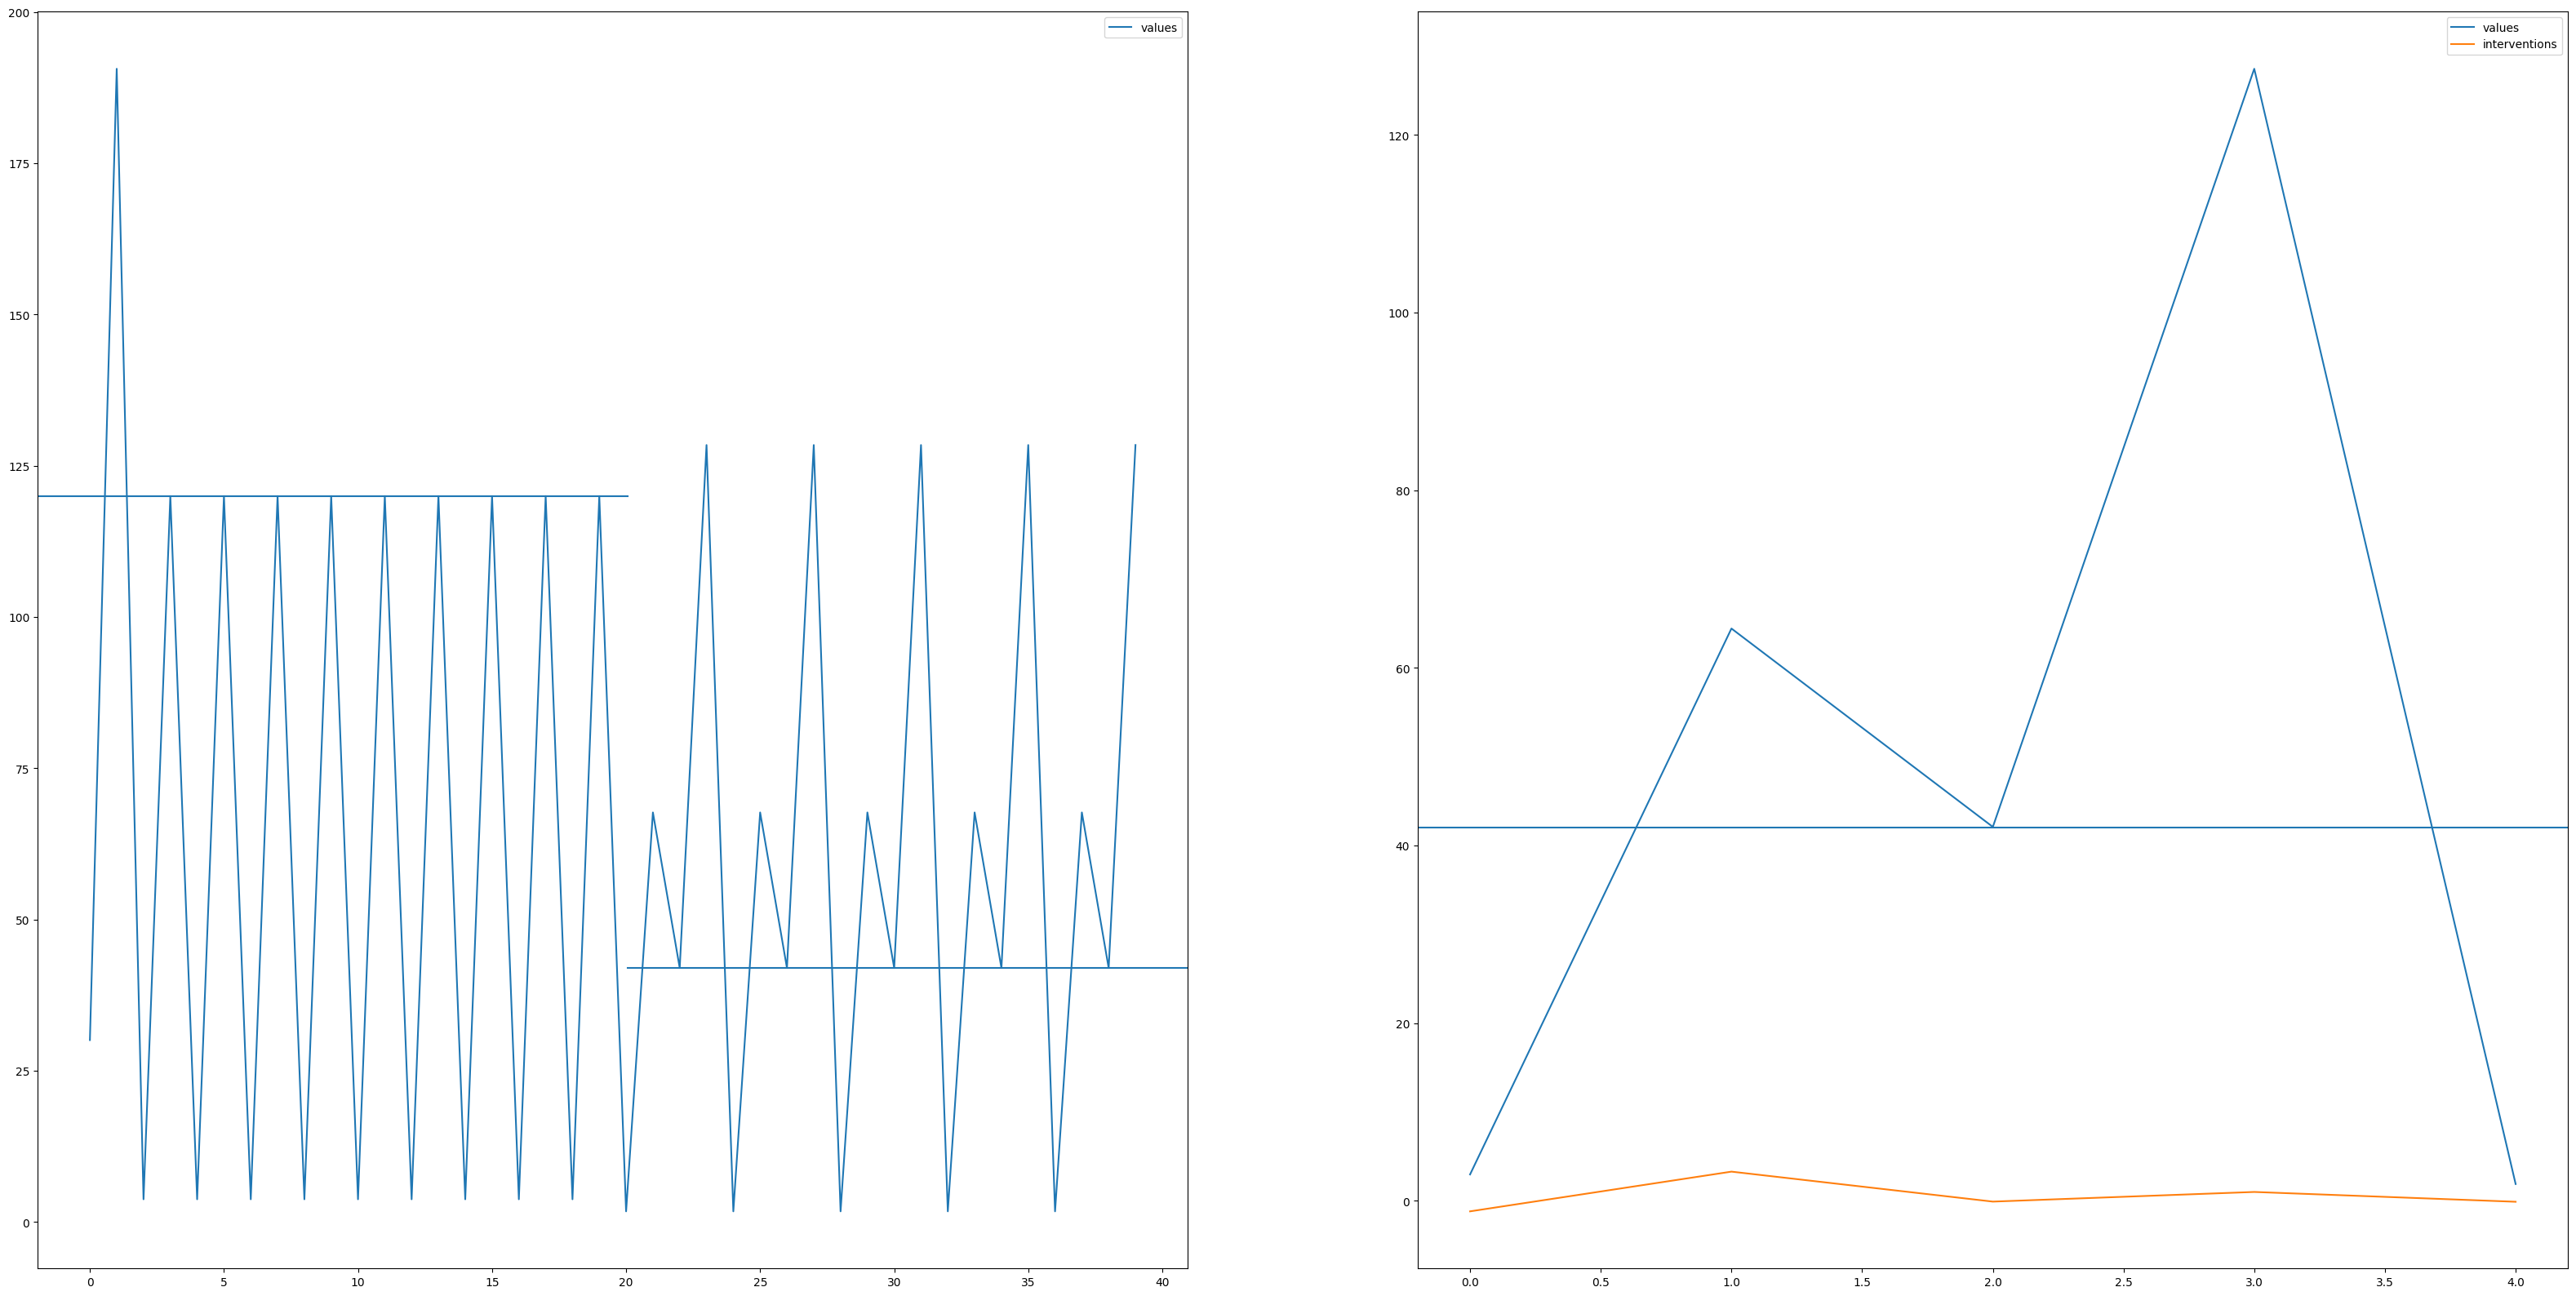

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

# # Show Plot of Regression
# n = np.linspace(0, gConst.max, gConst.N)
# ax1.set_xticks(n, np.arange(gConst.N), horizontalalignment="left", rotation=90)
# ax1.set_yticks(n, np.arange(gConst.N))
# ax1.grid()
# ax1.plot(np.arange(280), gConst.f(np.arange(280)), label="Regression")
# ax1.plot(np.arange(280), f(np.arange(280)), label="Ricker")
# ax1.set_xlim(0)
# ax1.set_ylim(0)
# ax1.legend()

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, 0, n1 / max(n))
ax1.axhline(t2, n1 / max(n), 1)
ax1.legend();

n = np.arange(len(testInt.values))
ax2.plot(n, testInt.values, label="values")
ax2.plot(n, testInt.interventions, label="interventions")
ax2.axhline(t2, 0, 1)
ax2.legend();

In [ ]:
n2 = len(all_vals)
t3 = 60
testInt.update_target(t3)

for i in range(20):
    int_val = testInt.intervention(x)
    all_vals.append(x+int_val)
    print("Intervention: ", int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    print("")

New target value 60.0 in node 48
Current node:  1
Shortest Path:  [48, 1]
Expected Path Length: 2
Intervention:  -0.30523604040874597
Next value:  58.04107960401259

Current node:  46
Best node:  48
Target reached using 2 steps
Intervention:  1.9589203959874126
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using previous path.
Intervention:  0.0
Next value:  60.0

Current node:  48
Using pr

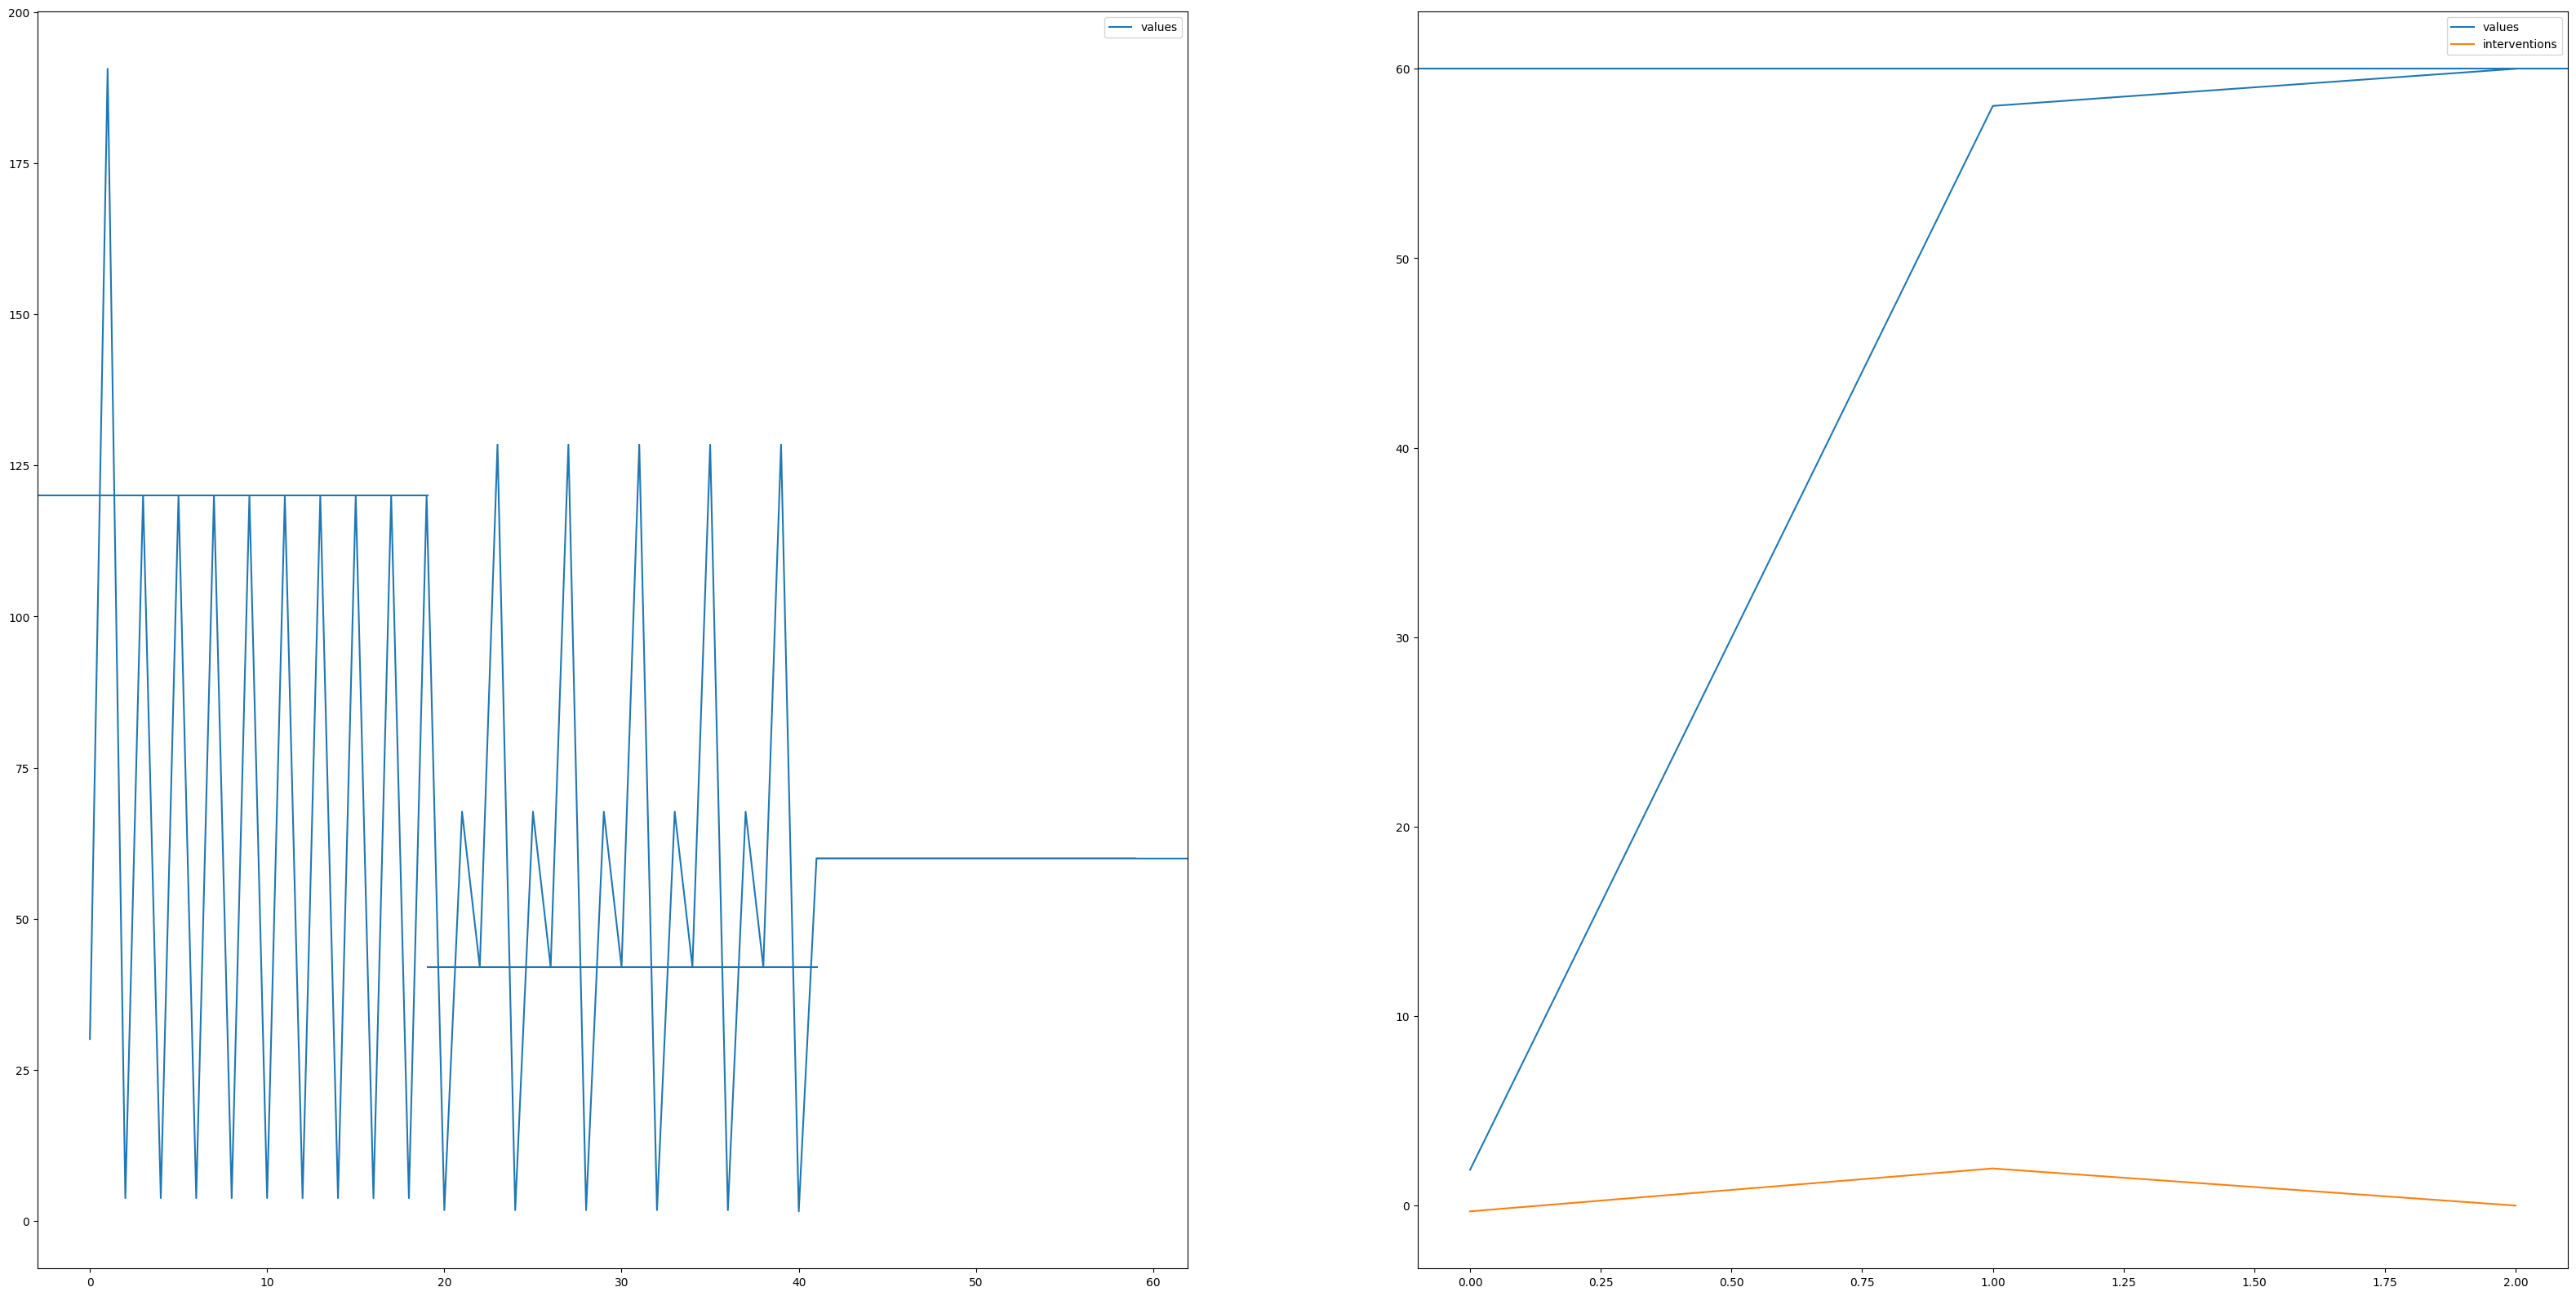

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

# # Show Plot of Regression
# n = np.linspace(0, gConst.max, gConst.N)
# ax1.set_xticks(n, np.arange(gConst.N), horizontalalignment="left", rotation=90)
# ax1.set_yticks(n, np.arange(gConst.N))
# ax1.grid()
# ax1.plot(np.arange(280), gConst.f(np.arange(280)), label="Regression")
# ax1.plot(np.arange(280), f(np.arange(280)), label="Ricker")
# ax1.set_xlim(0)
# ax1.set_ylim(0)
# ax1.legend()

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t, 0, n1 / max(n))
ax1.axhline(t2, n1 / max(n), n2 / max(n))
ax1.axhline(t3, n2 / max(n), 1)
ax1.legend();

n = np.arange(len(testInt.values))
ax2.plot(n, testInt.values, label="values")
ax2.plot(n, testInt.interventions, label="interventions")
ax2.axhline(t3, 0, 1)
ax2.legend();

##### Test 3: 2 Point Oscillation

In [ ]:
t1 = 170
t2 = 42
max_int = 25

Int1 = Interventor(gConst, t1, max_int)
Int2 = Interventor(gConst, t2, max_int)

switch = bool
all_vals = []

In [ ]:
x = 29
for i in range(20):

    if switch:
        int_val = Int1.intervention(x)
    else:
        int_val = Int2.intervention(x)

    print("Intervention: ", int_val)
    all_vals.append(x+int_val)

    if x+int_val == t1 or x+int_val == t2:
        switch = not switch

    x = f(x+int_val)
    print("Next value: ", x)
    print("")

Current node:  23
Best node:  5
Shortest Path:  [136, 5]
Expected Path Length: 2
Intervention:  -22.7109375
Next value:  172.60167664735428

Current node:  138
Best node:  136
Target reached using 2 steps
Intervention:  -2.6016766473542816
Next value:  0.19252391556243306

Current node:  0
Shortest Path:  [33, 0]
Expected Path Length: 2
Intervention:  0.8543510844375669
Next value:  39.69607214417864

Current node:  31
Best node:  33
Target reached using 2 steps
Intervention:  2.3039278558213567
Next value:  127.44305256629842

Current node:  101
Best node:  86
Shortest Path:  [136, 5, 86]
Expected Path Length: 3
Intervention:  -19.00555256629842
Next value:  5.469541562323977

Current node:  4
Best node:  5
Shortest Path:  [136, 5]
Expected Path Length: 2
Intervention:  0.8195209376760229
Next value:  172.60167664735428

Current node:  138
Using previous path.
Intervention:  -2.6016766473542816
Next value:  0.19252391556243306

Current node:  0
Using previous path.
Intervention:  0.85

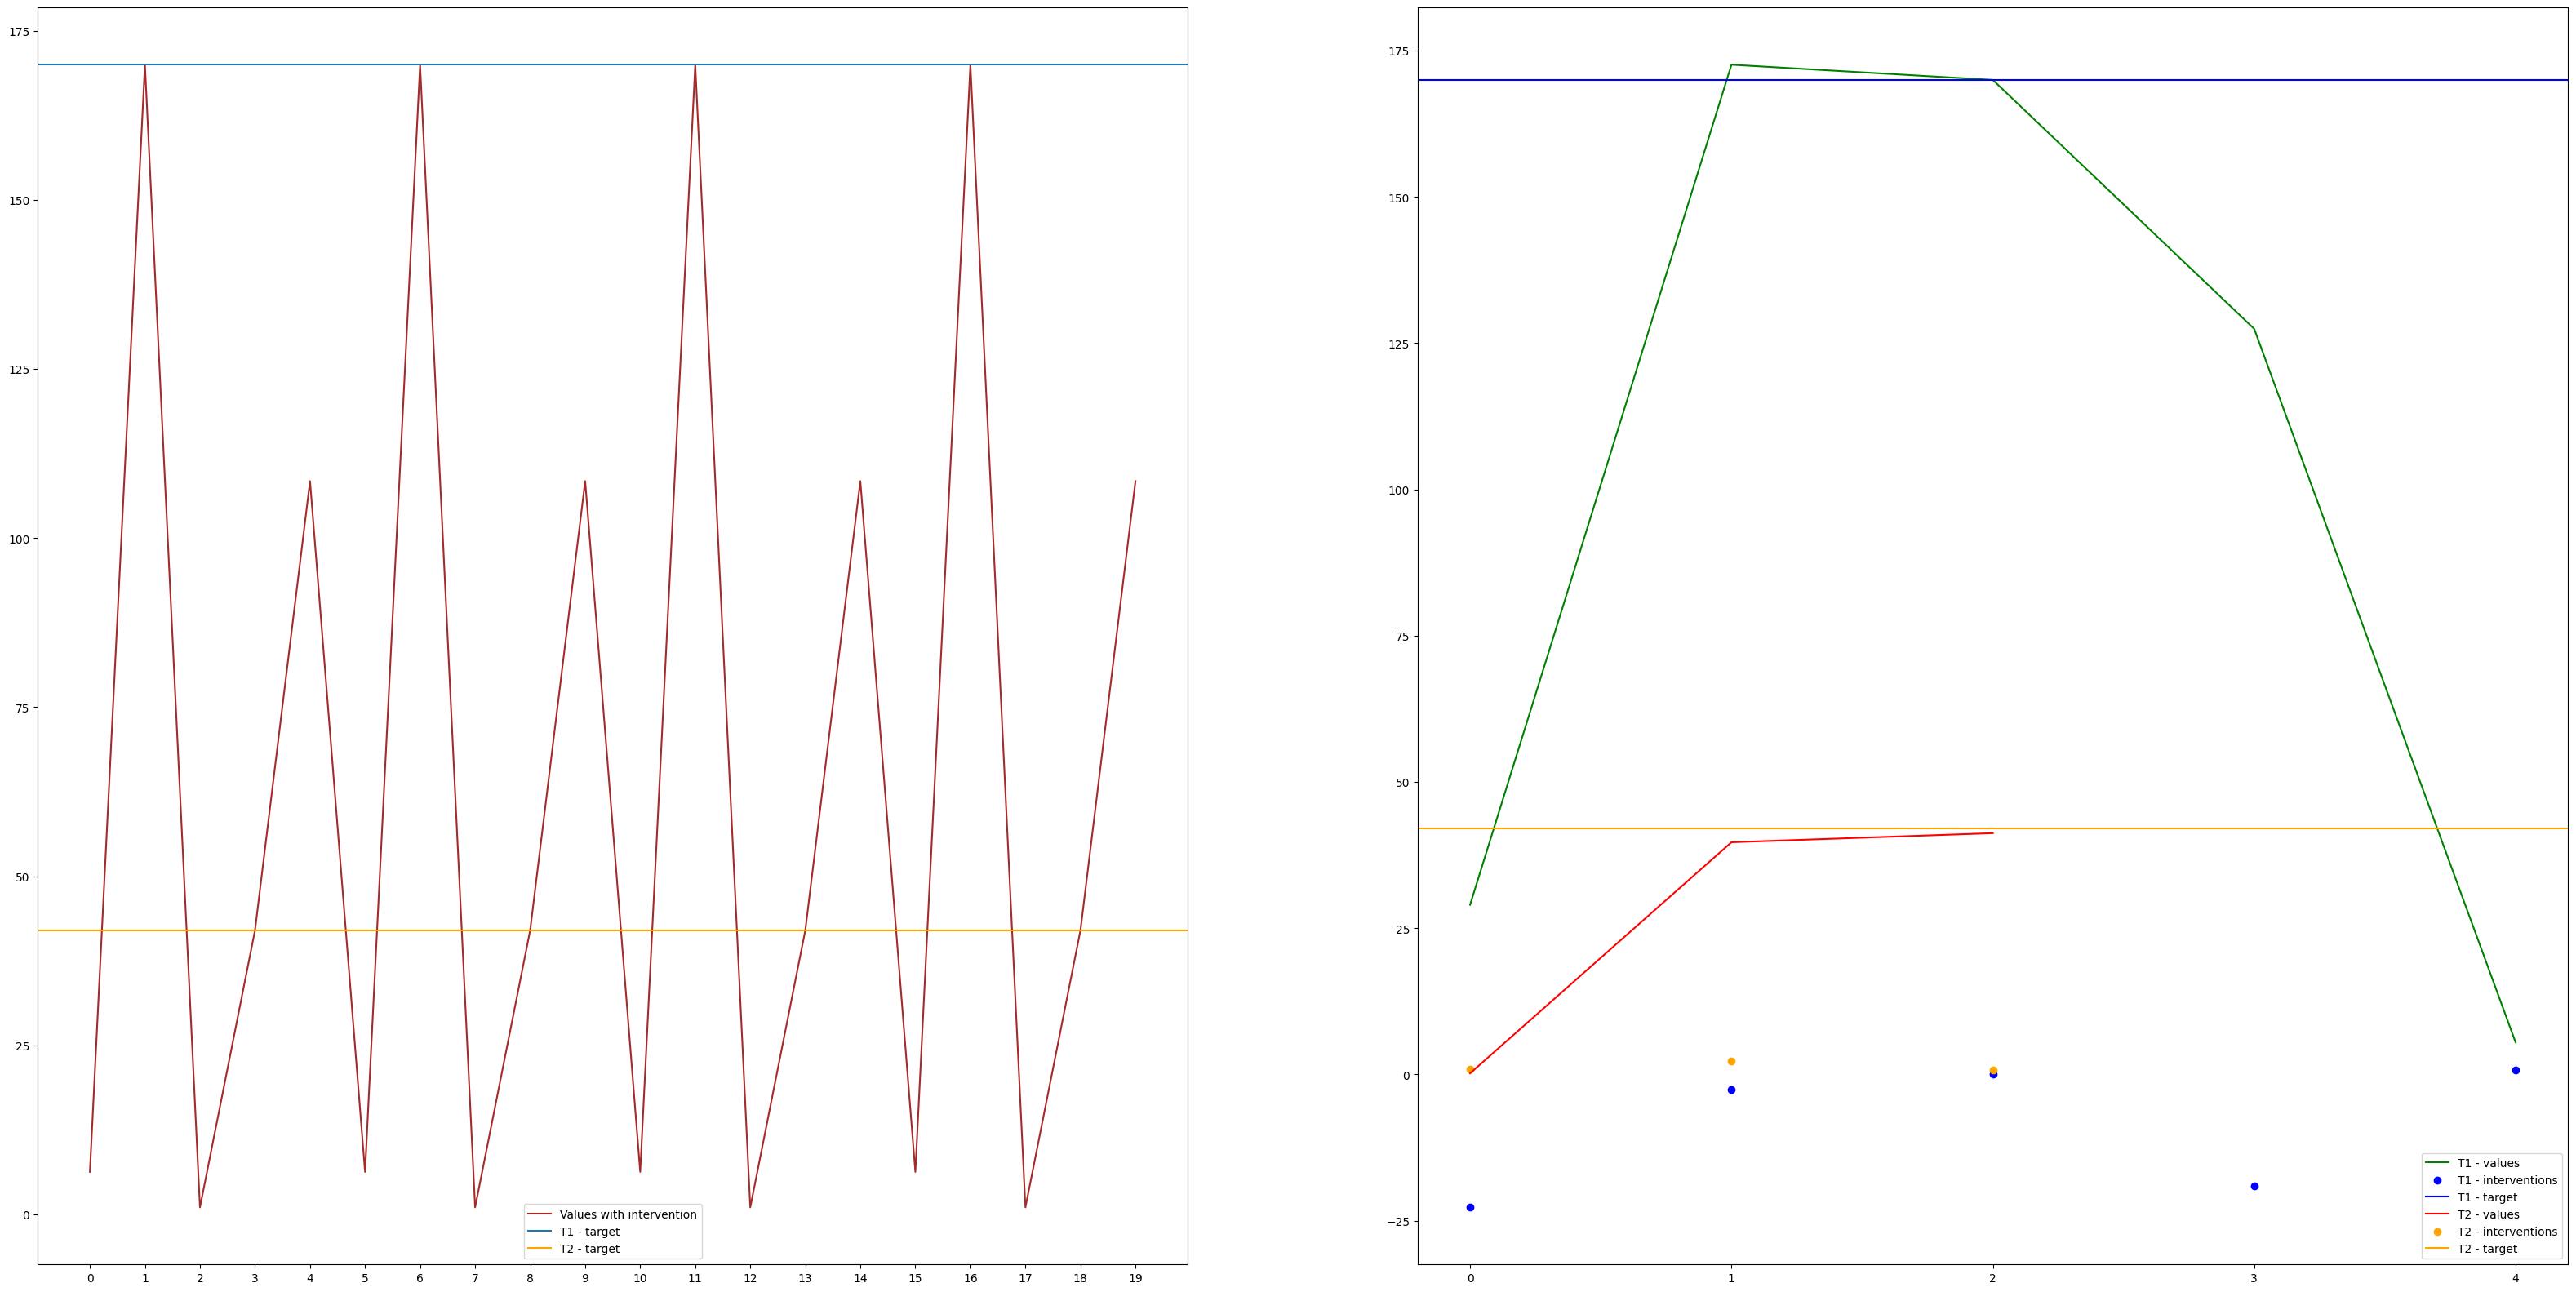

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, c="brown", label="Values with intervention")
ax1.axhline(t1, label="T1 - target")
ax1.axhline(t2, c="orange", label="T2 - target")
ax1.set_xticks(n)
ax1.legend();

n1 = np.arange(len(Int1.values))
ax2.plot(n1, Int1.values, c="green", label="T1 - values")
ax2.scatter(n1, Int1.interventions, c="blue", label="T1 - interventions")
ax2.axhline(t1, c="blue", label="T1 - target")

n2 = np.arange(len(Int2.values))
ax2.plot(n2, Int2.values, c="red", label="T2 - values")
ax2.scatter(n2, Int2.interventions, c="orange", label="T2 - interventions")
ax2.axhline(t2, c="orange", label="T2 - target")
ax2.set_xticks(n1 if n1[-1] > n2[-1] else n2)
ax2.legend();

##### Test 4: Few samples

In [ ]:
data = make_samples(1, 50, f, f.max_val, noise=0.25)
data.max()

253.57854150103574

In [ ]:
gConst= GraphConstructor(100, x=data[:-1], y=data[1:], min_val=0, max_val=250, automatic_padding="max")

In [ ]:
t = 45
max_int = 25
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [ ]:
x = 29
for i in range(20):
    int_val = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    print("")

Current node:  11
Best node:  18
Target reached using 1 steps
Intervention:  16.0
Next value:  113.48407171611666

Current node:  45
Best node:  50
Shortest Path:  [18, 0, 50]
Expected Path Length: 3
Intervention:  13.39092828388334
Next value:  2.052880679875986

Current node:  0
Shortest Path:  [18, 0]
Expected Path Length: 2
Intervention:  -0.9380158150111213
Next value:  42.09728293044782

Current node:  16
Best node:  18
Target reached using 4 steps
Intervention:  2.902717069552182
Next value:  113.48407171611666

Current node:  45
Using previous path.
Intervention:  13.39092828388334
Next value:  2.052880679875986

Current node:  0
Using previous path.
Intervention:  -0.9380158150111213
Next value:  42.09728293044782

Current node:  16
Using previous path.
Intervention:  2.902717069552182
Next value:  113.48407171611666

Current node:  45
Using previous path.
Intervention:  13.39092828388334
Next value:  2.052880679875986

Current node:  0
Using previous path.
Intervention:  -0.9

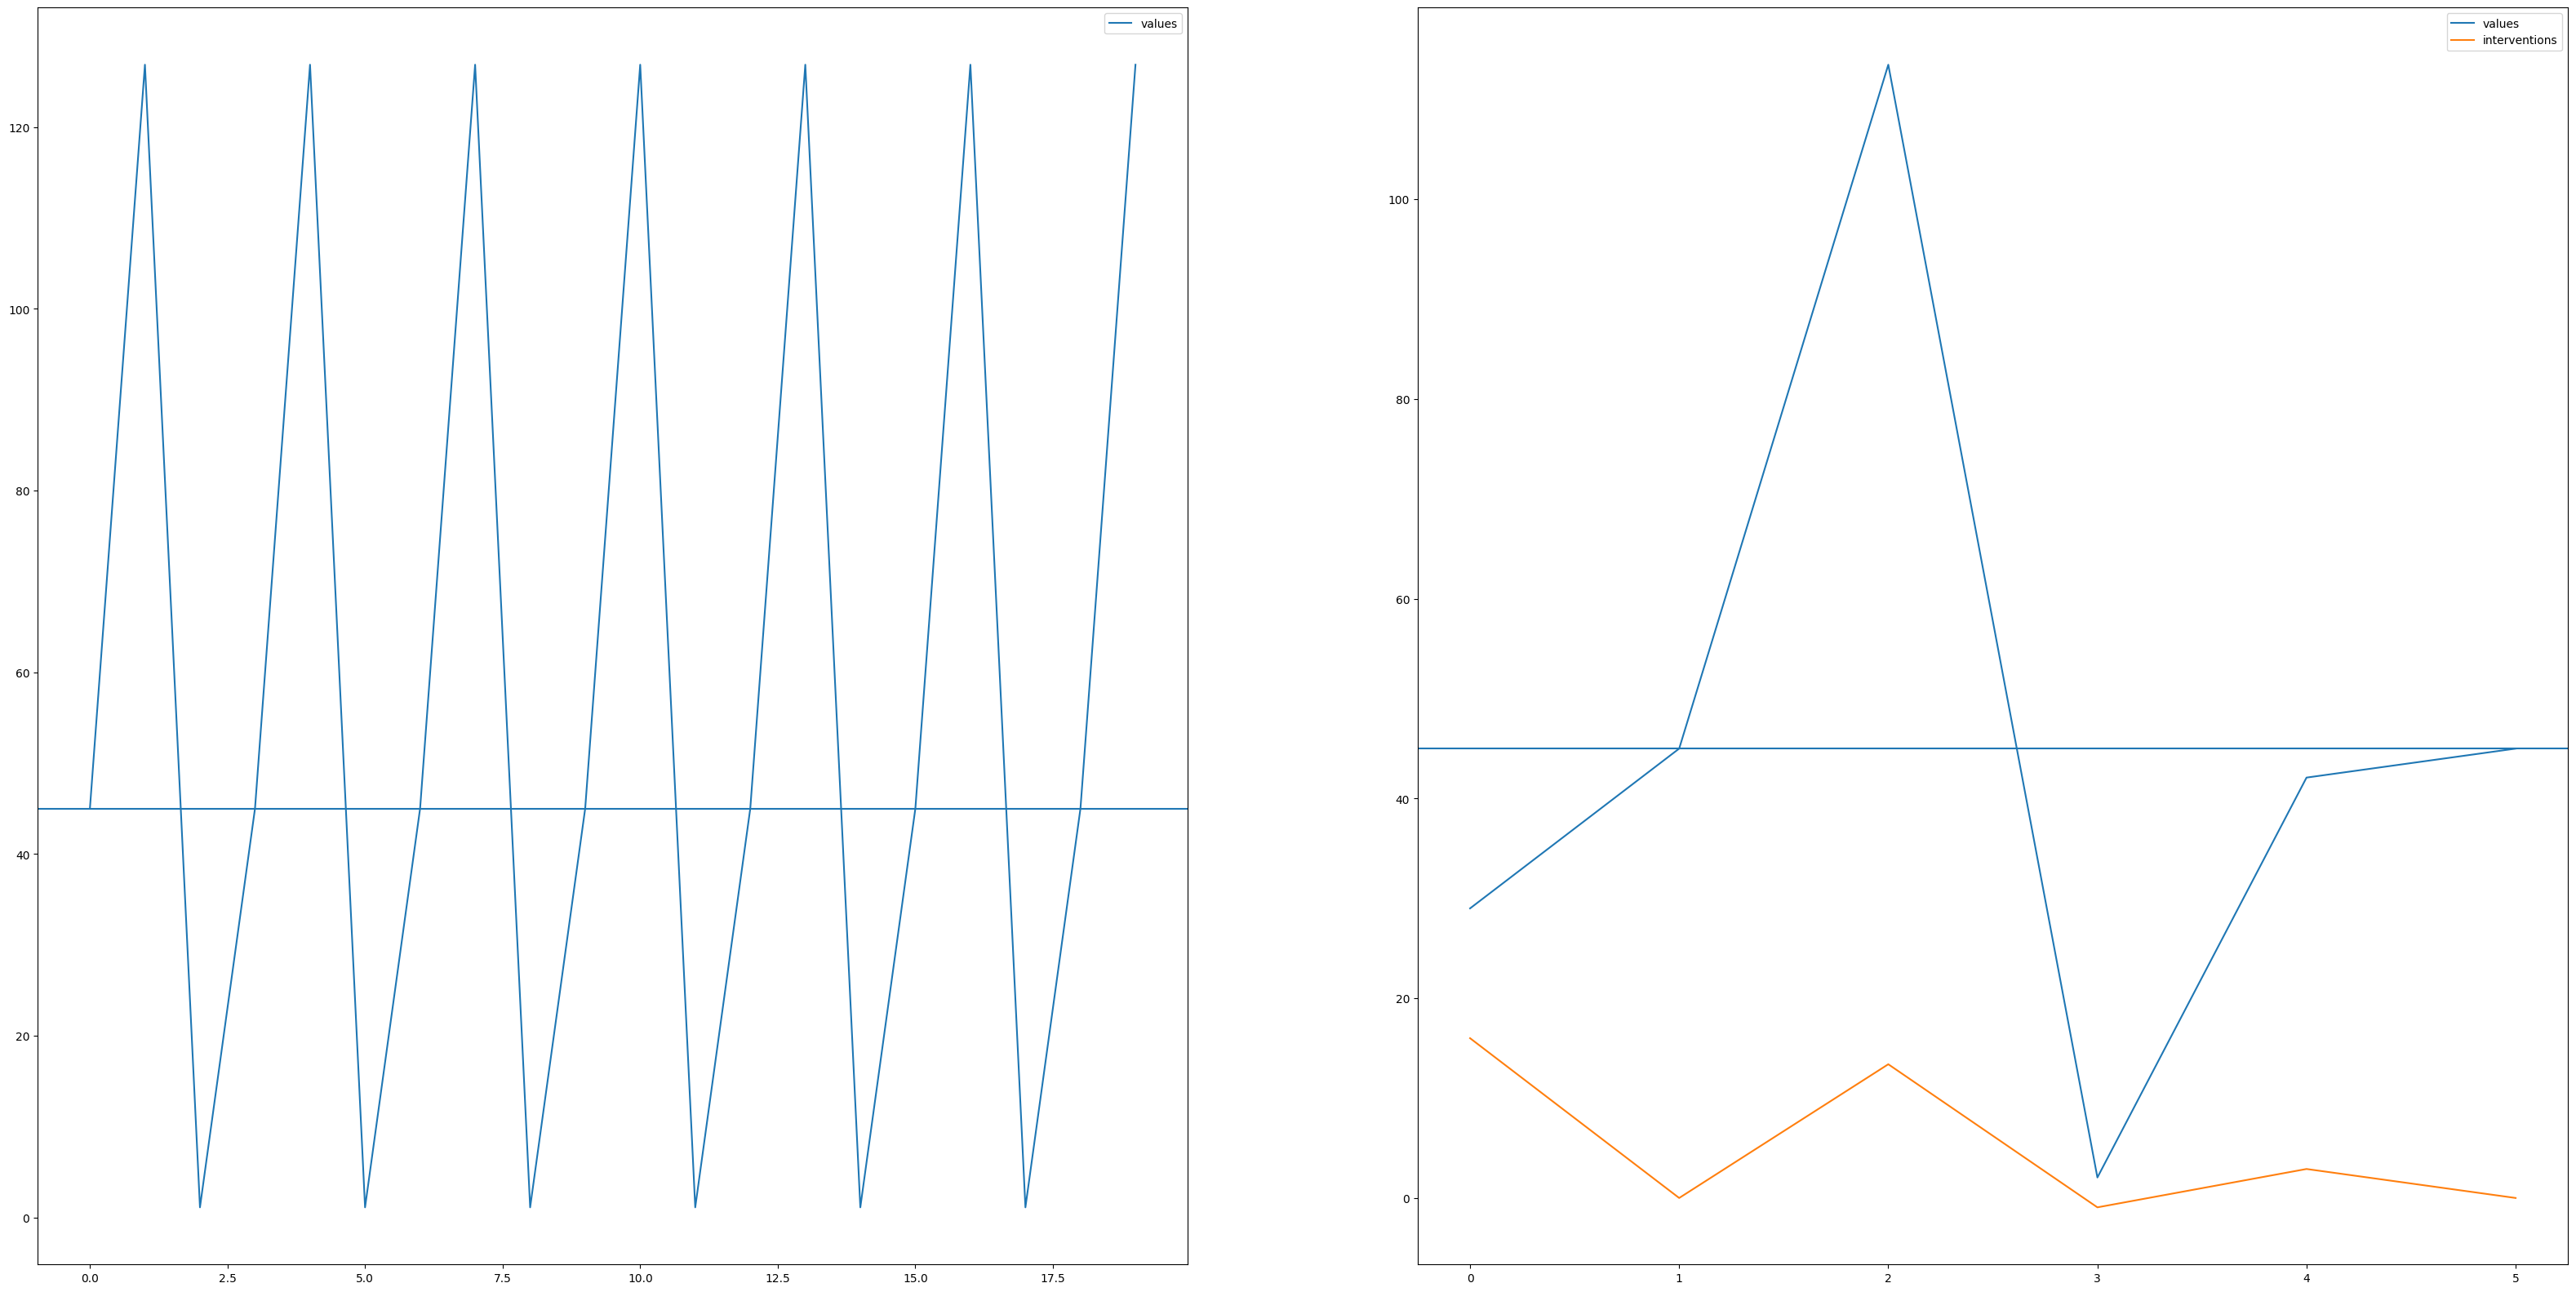

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t)
ax1.legend();

n = np.arange(len(testInt.values))
ax2.plot(n, testInt.values, label="values")
ax2.plot(n, testInt.interventions, label="interventions")
ax2.axhline(t)
ax2.legend();

##### Test 5: Few samples High Granularity

In [ ]:
data = make_samples(1, 20, f, f.max_val, noise=0.25)
data.max()

253.02312571058042

In [ ]:
gConst= GraphConstructor(1000, x=data[:-1], y=data[1:], min_val=0, max_val=250, automatic_padding="max")
rm = gConst.get_regression_matrix()

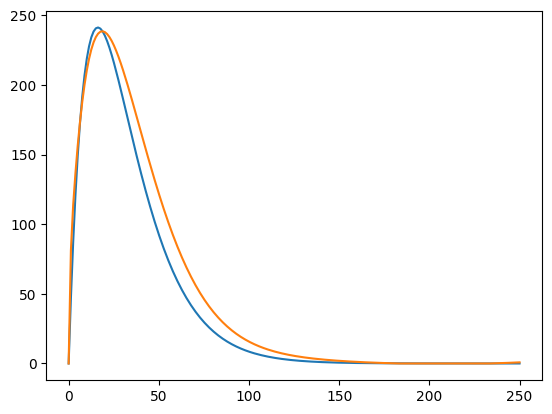

In [ ]:
n = np.linspace(0, 250, 200)
plt.plot(n, f(n), label="Logistic")
plt.plot(n, gConst.f(n), label="Regression")

In [ ]:
t = 45
max_int = 5
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [ ]:
x = 29
for i in range(20):
    int_val = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Next value: ", x)
    print("")

Current node:  116
Shortest Path:  [180, 2, 0, 856, 116]
Expected Path Length: 5
Intervention:  0.27500000000000213
Next value:  194.69655976685934

Current node:  778
Shortest Path:  [180, 2, 0, 778]
Expected Path Length: 4
Intervention:  -0.07155976685933751
Next value:  0.048276983217404375

Current node:  0
Best node:  2
Shortest Path:  [180, 2]
Expected Path Length: 2
Intervention:  0.48770786526744414
Next value:  20.97430705185178

Current node:  83
Shortest Path:  [180, 2, 0, 948, 83]
Expected Path Length: 5
Intervention:  -0.036807051851781125
Next value:  232.85035086413168

Current node:  931
Shortest Path:  [180, 2, 0, 931]
Expected Path Length: 4
Intervention:  0.024649135868315852
Next value:  0.005461001008831766

Current node:  0
Best node:  2
Shortest Path:  [180, 2]
Expected Path Length: 2
Intervention:  0.5305238474760168
Next value:  20.97430705185178

Current node:  83
Shortest Path:  [180, 2, 0, 948, 83]
Expected Path Length: 5
Intervention:  -0.036807051851781125

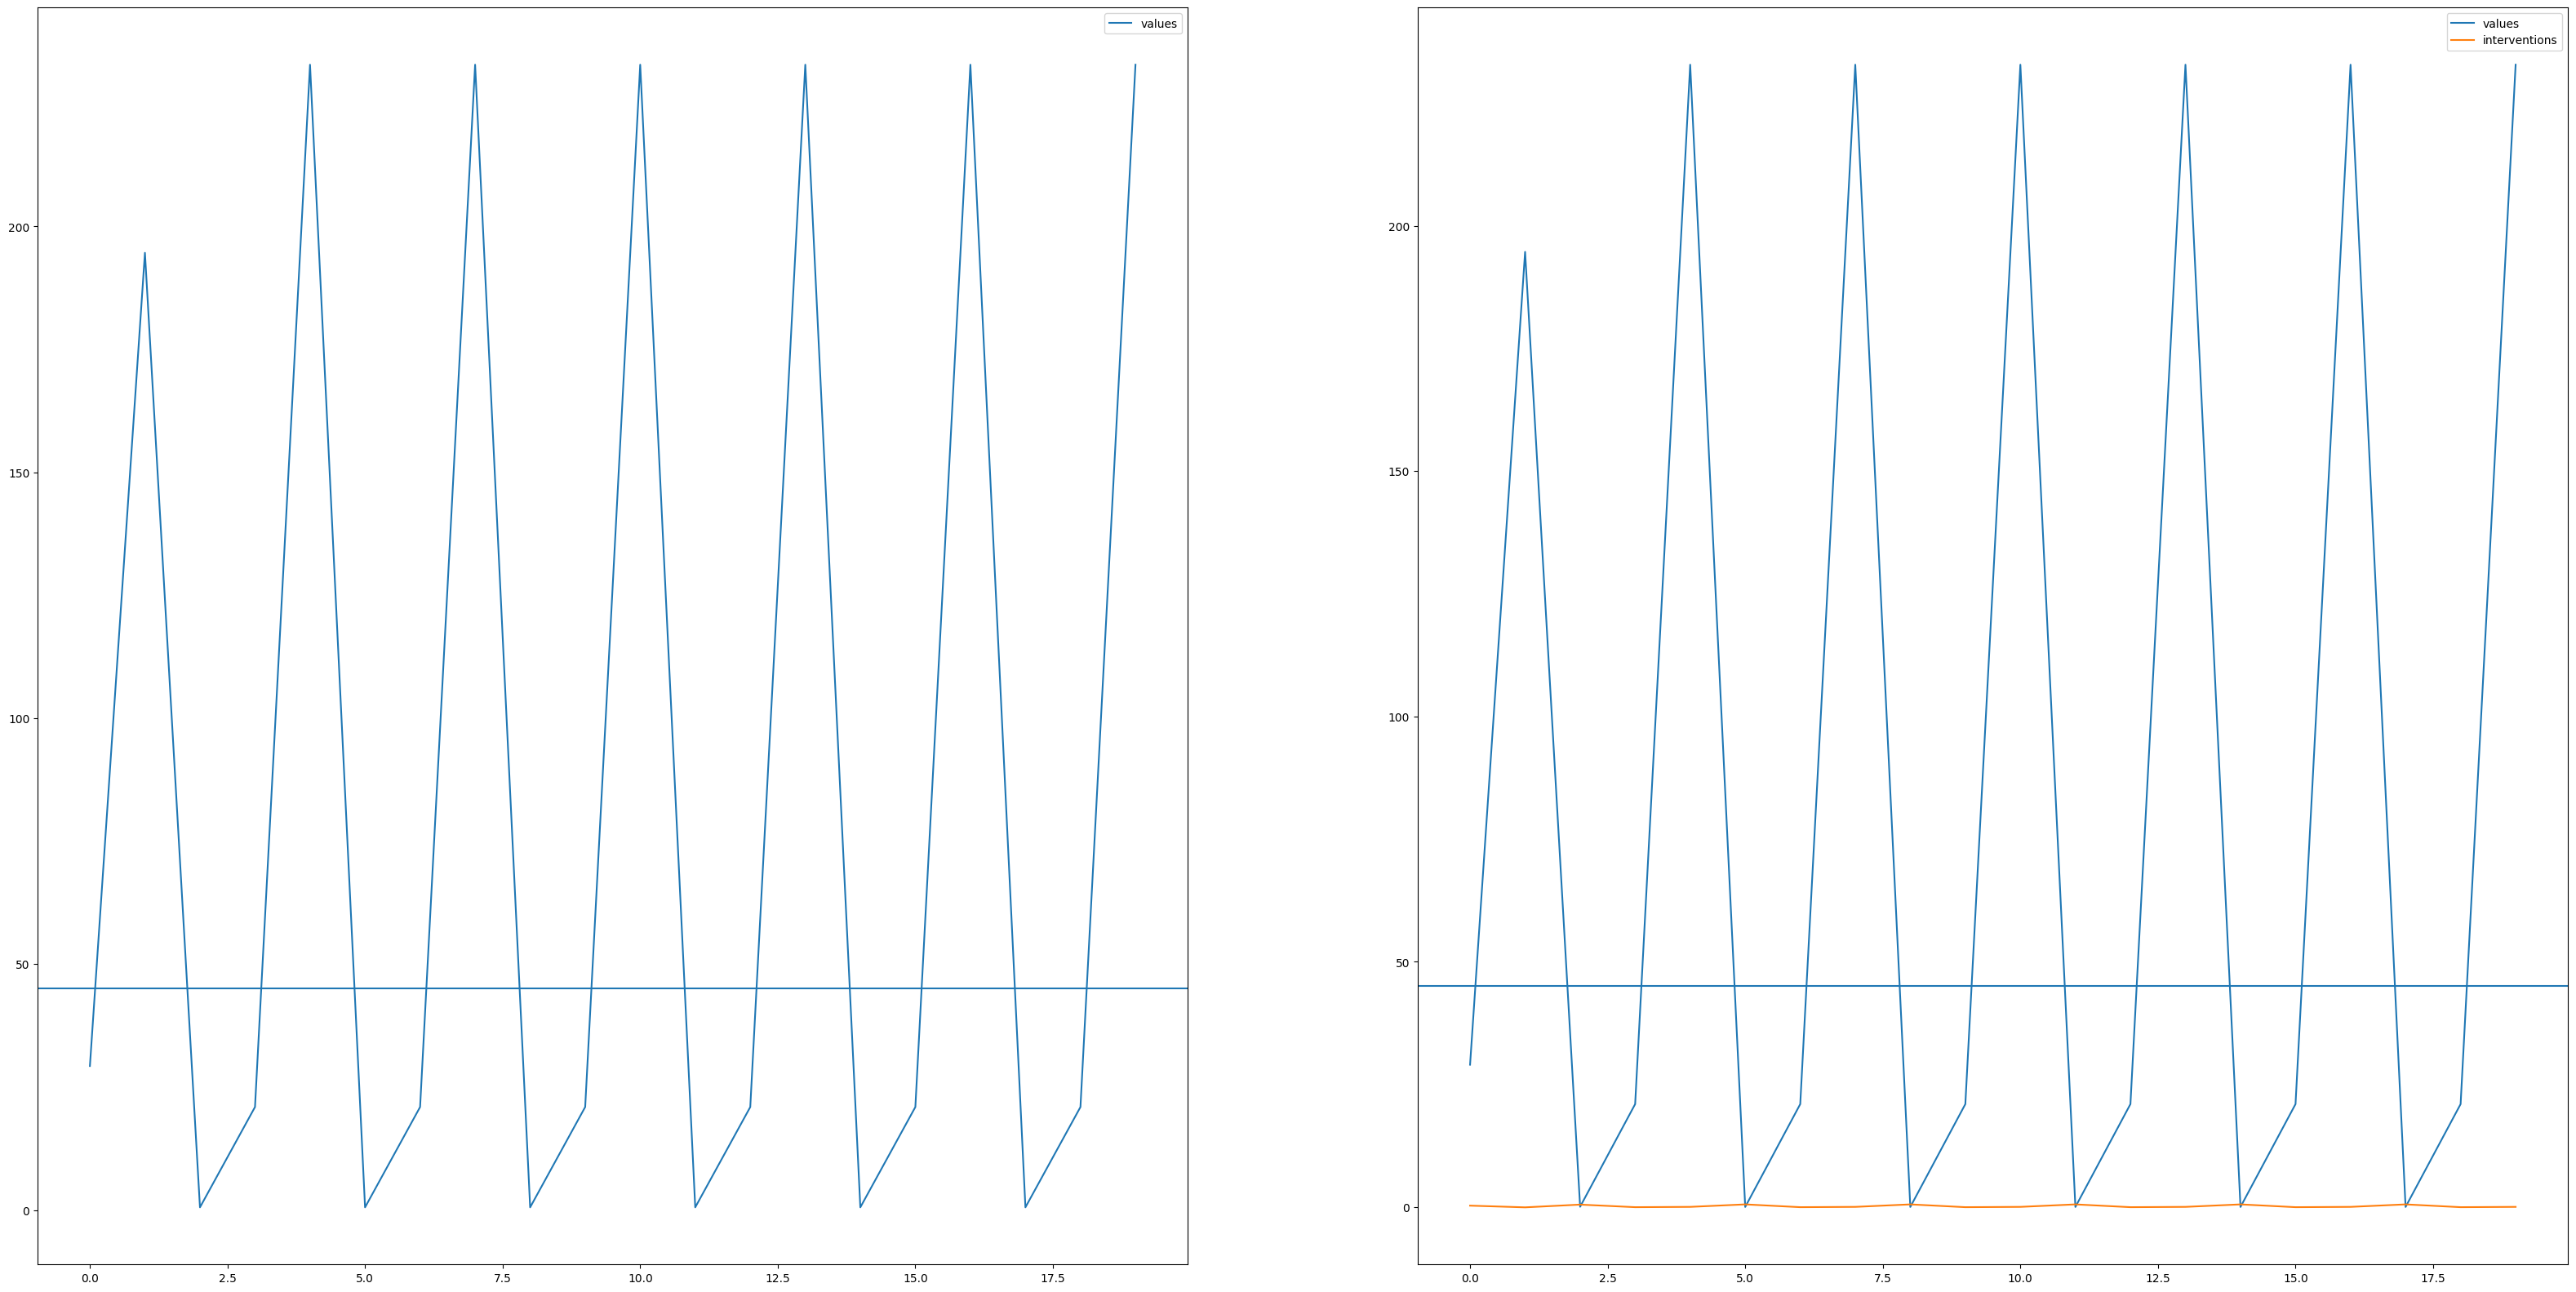

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t)
ax1.legend();

n = np.arange(len(testInt.values))
ax2.plot(n, testInt.values, label="values")
ax2.plot(n, testInt.interventions, label="interventions")
ax2.axhline(t)
ax2.legend();

##### Test 6: Logistic

In [ ]:
data = make_samples(1, 200, g, g.max_val, noise=0.05, limit=True)
gConst= GraphConstructor(100, x=data[:-1], y=data[1:], min_val=0, max_val=1, automatic_padding="max")
data.max()

1.0338746801677938

In [ ]:
gConst= GraphConstructor(100, x=data[:-1], y=data[1:], min_val=0, max_val=1, automatic_padding="max")

In [ ]:
t = 0.3
max_int = 0.05
testInt = Interventor(gConst, t, max_int)

all_vals = []

In [ ]:
x = 0.1
for i in range(20):
    int_val = testInt.intervention(x)
    print("Intervention: ", int_val)
    all_vals.append(x+int_val)
    x = g(x+int_val)
    print("Next value: ", x)
    print("")

Current node:  10
Best node:  8
Shortest Path:  [29, 8]
Expected Path Length: 2
Intervention:  -0.01625
Next value:  0.30694375

Current node:  30
Best node:  29
Target reached using 2 steps
Intervention:  -0.006943750000000026
Next value:  0.84

Current node:  83
Best node:  79
Shortest Path:  [29, 91, 64, 79]
Expected Path Length: 4
Intervention:  -0.0462499999999999
Next value:  0.6548437499999998

Current node:  65
Shortest Path:  [29, 91, 65]
Expected Path Length: 3
Intervention:  -0.0023437499999998668
Next value:  0.9069750000000001

Current node:  90
Best node:  91
Shortest Path:  [29, 91]
Expected Path Length: 2
Intervention:  0.0067749999999999755
Next value:  0.31524374999999977

Current node:  31
Best node:  29
Target reached using 6 steps
Intervention:  -0.015243749999999778
Next value:  0.84

Current node:  83
Using previous path.
Intervention:  -0.0462499999999999
Next value:  0.6548437499999998

Current node:  65
Using previous path.
Intervention:  -0.002343749999999866

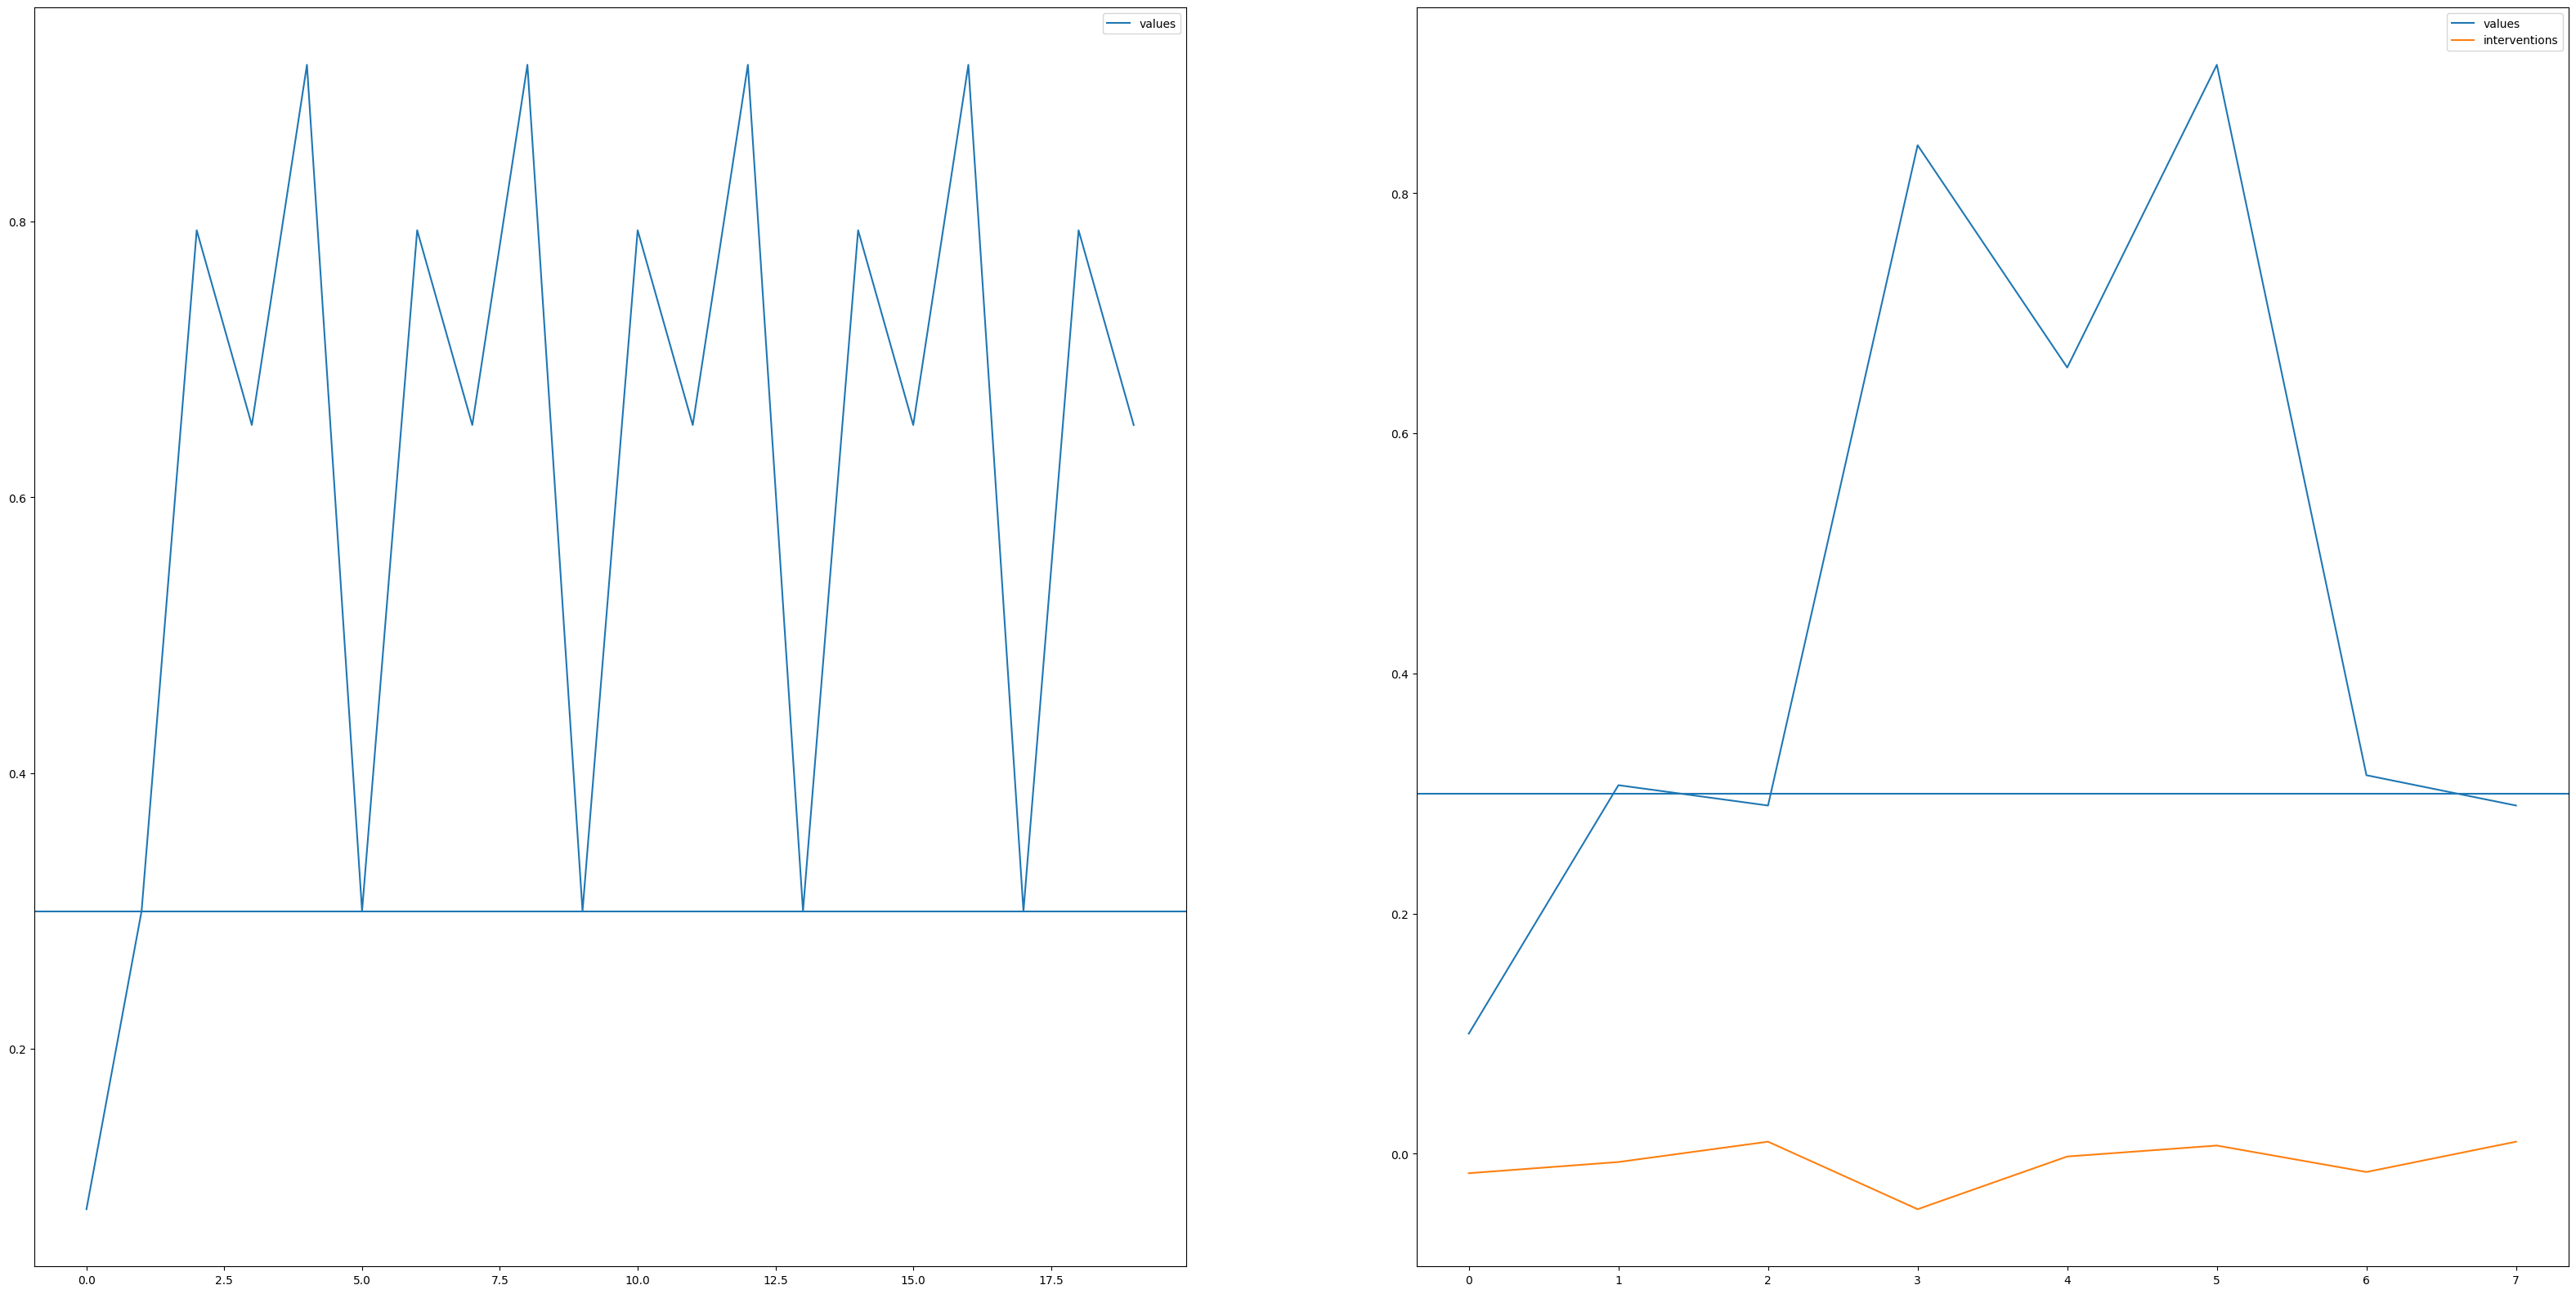

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.axhline(t)
ax1.legend();

n = np.arange(len(testInt.values))
ax2.plot(n, testInt.values, label="values")
ax2.plot(n, testInt.interventions, label="interventions")
ax2.axhline(t)
ax2.legend();

### Finding Fixed Points

In [ ]:
class Stabilizer:

    def __init__(self, gConst, max_intervention=np.inf):
        self.gConst = gConst
        self.G = gConst.G
        self.e = gConst.e

        loops = list(nx.simple_cycles(self.G, 1))

        if len(loops) == 0:
            print("No possible fixed points found!")
            self.flag = False
            return

        print("Possible fixed points:", loops)
        self.t_node = None
        while not [self.t_node] in loops:
            self.t_node = int(input("Choose point for stabilization: "))
        self.flag = True

        self.t_val = (self.t_node + 0.5) * self.e
        self.pivot = self.t_val
        self.interventor = Interventor(self.gConst, self.t_val, max_intervention)

        self.found = False
        self.p_step = 0
        self.current_diff = 0
        self.m = 0.5

        self.targets = []

    def stabilize(self, x, epsilon=1e-3):

        self.targets.append(self.t_val)

        if not self.flag:
            return None

        # go to the target
        if not self.interventor.reached or self.found:
            return self.interventor.intervention(x)


        diff = abs(self.t_val - x)

        # if difference is smaller than epsilon, fixed point is found
        if diff < epsilon:
            print("Approached fixed point at", self.t_val)
            self.found = True
            return self.interventor.intervention(x)


        if self.p_step == 0:
            self._step0(diff)
        elif self.p_step != 3 and self.p_step != 4:
            self._step12(diff)
        else:
            self._step34(diff)

        self.interventor.update_target(self.t_val)
        return self.interventor.intervention(x)


    # Assign first pivot
    def _step0(self, diff):
        self.pivot_diff = diff
        self.t_val = self.pivot + self.m * self.e
        self.p_step = 1


    # Go in the direction until diff increases
    def _step12(self, diff):
        # If difference on one side is slower update pivot und set new target
        if self.pivot_diff > diff:
            self.pivot = self.t_val
            self.pivot_diff = diff
            self.t_val = self.pivot + self.m * self.e

        # otherwise move to the other side
        else:
            self.m *= -1
            self.pivot += self.m * self.e
            self.t_val = self.pivot
            # if already changed sides, move on with decreasing step size (step3)
            if self.p_step == 1:
                self.p_step = 2
            else:
                self.p_step = 3


    def _step34(self, diff):
        # If difference on one side is slower update pivot und set new target
        # The stepsize (m) now decreases
        if self.pivot_diff > diff:
            self.pivot = self.t_val
            self.pivot_diff = diff
            self.m /= 2

        # otherwise move to the other side
        elif self.p_step == 3:
            self.m *= -1
            self.p_step = 4

        # if both sides are further away go closer to the pivot
        else:
            self.p_step = 3
            self.m /= -2

        self.t_val = self.pivot + self.m * self.e

#### Test 1: Ricker Function 1

In [ ]:
f = RickerFunction(K=123.469)
data = make_samples(1, 1000, f, f.max_val, noise=0.1)
gConst= GraphConstructor(200, x=data[:-1], y=data[1:], min_val=0, max_val=250, automatic_padding="max", verbose=False)
rm = gConst.get_regression_matrix(-1, force_new=True)
G = gConst.create_graph()

In [ ]:
x = 134
max_int = 5
stab = Stabilizer(gConst, max_int)
all_vals = []
print("")
for i in range(40):
    int_val = stab.stabilize(x)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Intervention: ", int_val)
    print("Next value: ", x)
    print("")

Possible fixed points: [[0], [97]]
Choose point for stabilization: 97

Current node:  107
Best node:  109
Shortest Path:  [97, 2, 216, 6, 198, 70, 109]
Expected Path Length: 7
Intervention:  3.7083333333333144
Next value:  89.87567294848269

Current node:  71
Shortest Path:  [97, 2, 216, 7, 194, 71]
Expected Path Length: 6
Intervention:  -0.6048396151493449
Next value:  248.76098121528668

Current node:  199
Shortest Path:  [97, 2, 216, 6, 199]
Expected Path Length: 5
Intervention:  0.6140187847133234
Next value:  5.731218267621459

Current node:  4
Best node:  2
Shortest Path:  [97, 2]
Expected Path Length: 2
Intervention:  -2.477541797033224
Next value:  119.37652074431404

Current node:  95
Best node:  97
Target reached using 5 steps
Intervention:  2.4984792556859645
Next value:  127.83794218869595

New target value 122.5 in node 98
Current node:  102
Best node:  99
Shortest Path:  [98, 2, 216, 66, 112, 92, 99]
Expected Path Length: 7
Intervention:  -3.0462755220292905
Next value:  

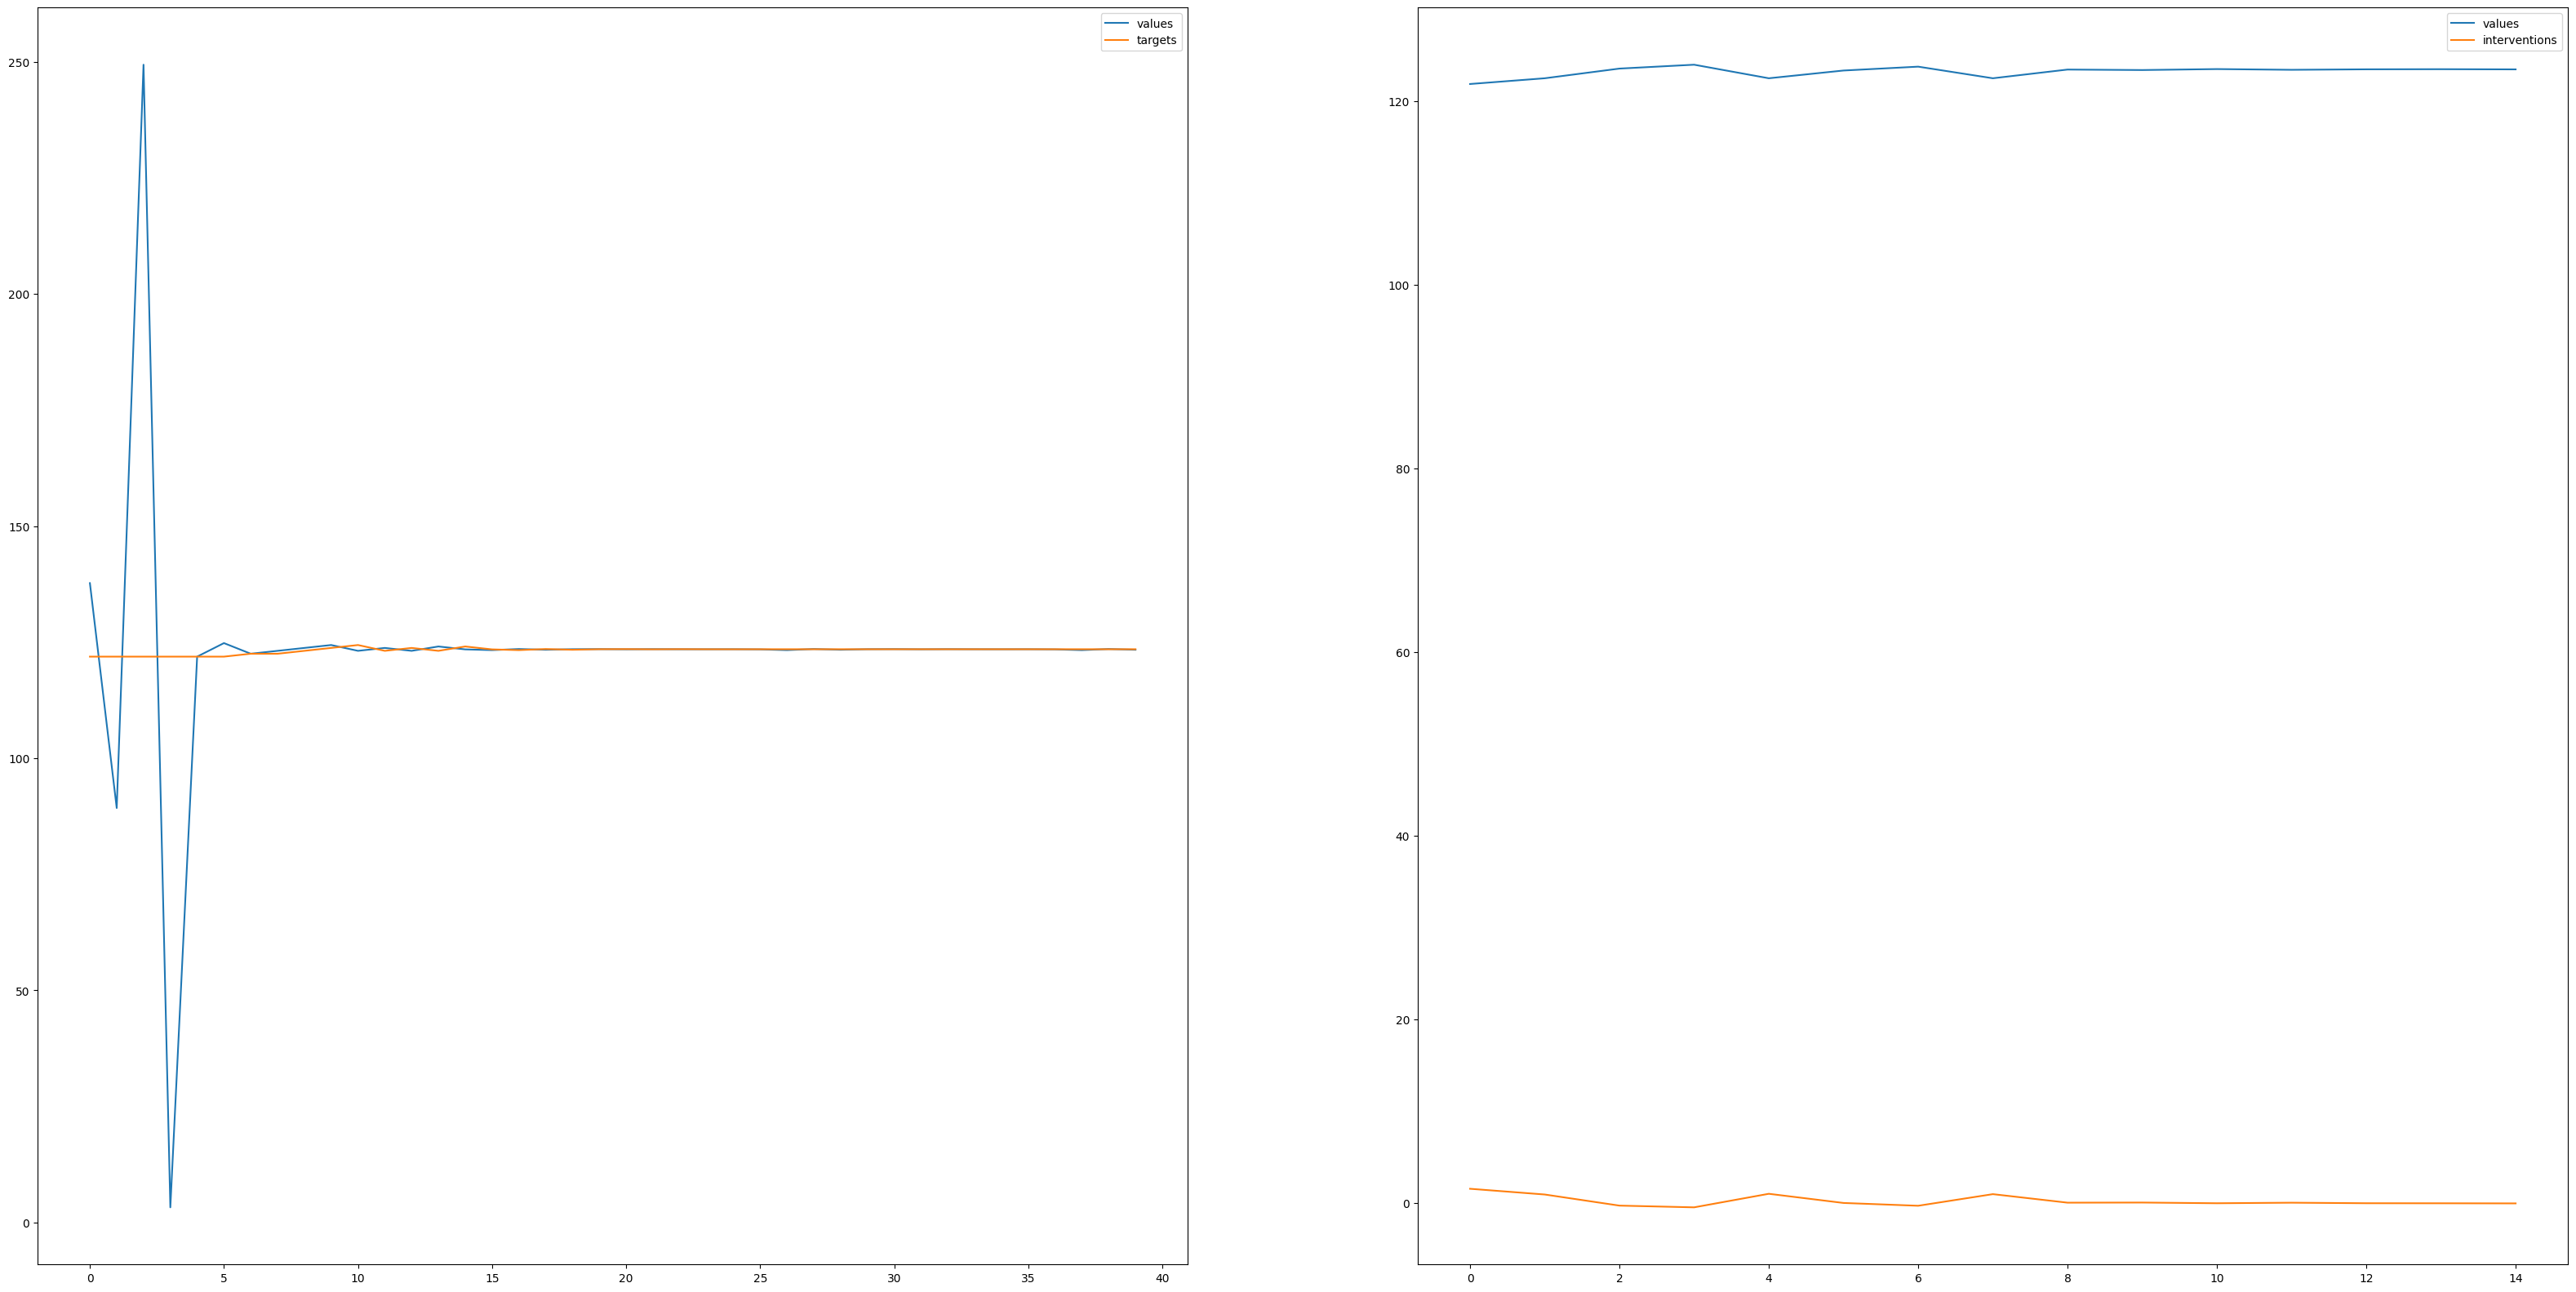

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.plot(n, stab.targets, label="targets")
ax1.legend();

n = np.arange(len(stab.interventor.values))
ax2.plot(n, stab.interventor.values, label="values")
ax2.plot(n, stab.interventor.interventions, label="interventions")
ax2.legend();

#### Test 2: Ricker Function 2

In [ ]:
x = 254
max_int = 5
stab = Stabilizer(gConst, max_int)
all_vals = []
print("")
for i in range(40):
    int_val = stab.stabilize(x)
    all_vals.append(x+int_val)
    x = f(x+int_val)
    print("Intervention: ", int_val)
    print("Next value: ", x)
    print("")

Possible fixed points: [[0], [97]]
Choose point for stabilization: 97

Current node:  203
Best node:  200
Shortest Path:  [97, 2, 216, 6, 200]
Expected Path Length: 5
Intervention:  -3.375
Next value:  5.548176611835688

Current node:  4
Best node:  2
Shortest Path:  [97, 2]
Expected Path Length: 2
Intervention:  -2.294500141247452
Next value:  119.37652074431404

Current node:  95
Best node:  97
Target reached using 3 steps
Intervention:  2.4984792556859645
Next value:  127.83794218869595

New target value 122.5 in node 98
Current node:  102
Best node:  99
Shortest Path:  [98, 2, 216, 66, 112, 92, 99]
Expected Path Length: 7
Intervention:  -3.0462755220292905
Next value:  119.94211845910205

Current node:  95
Best node:  98
Target reached using 2 steps
Intervention:  2.5578815408979523
Next value:  126.1093122172365

New target value 123.125 in node 98
Current node:  100
Best node:  98
Target reached using 1 steps
Intervention:  -2.984312217236507
Next value:  124.40081851247798

New 

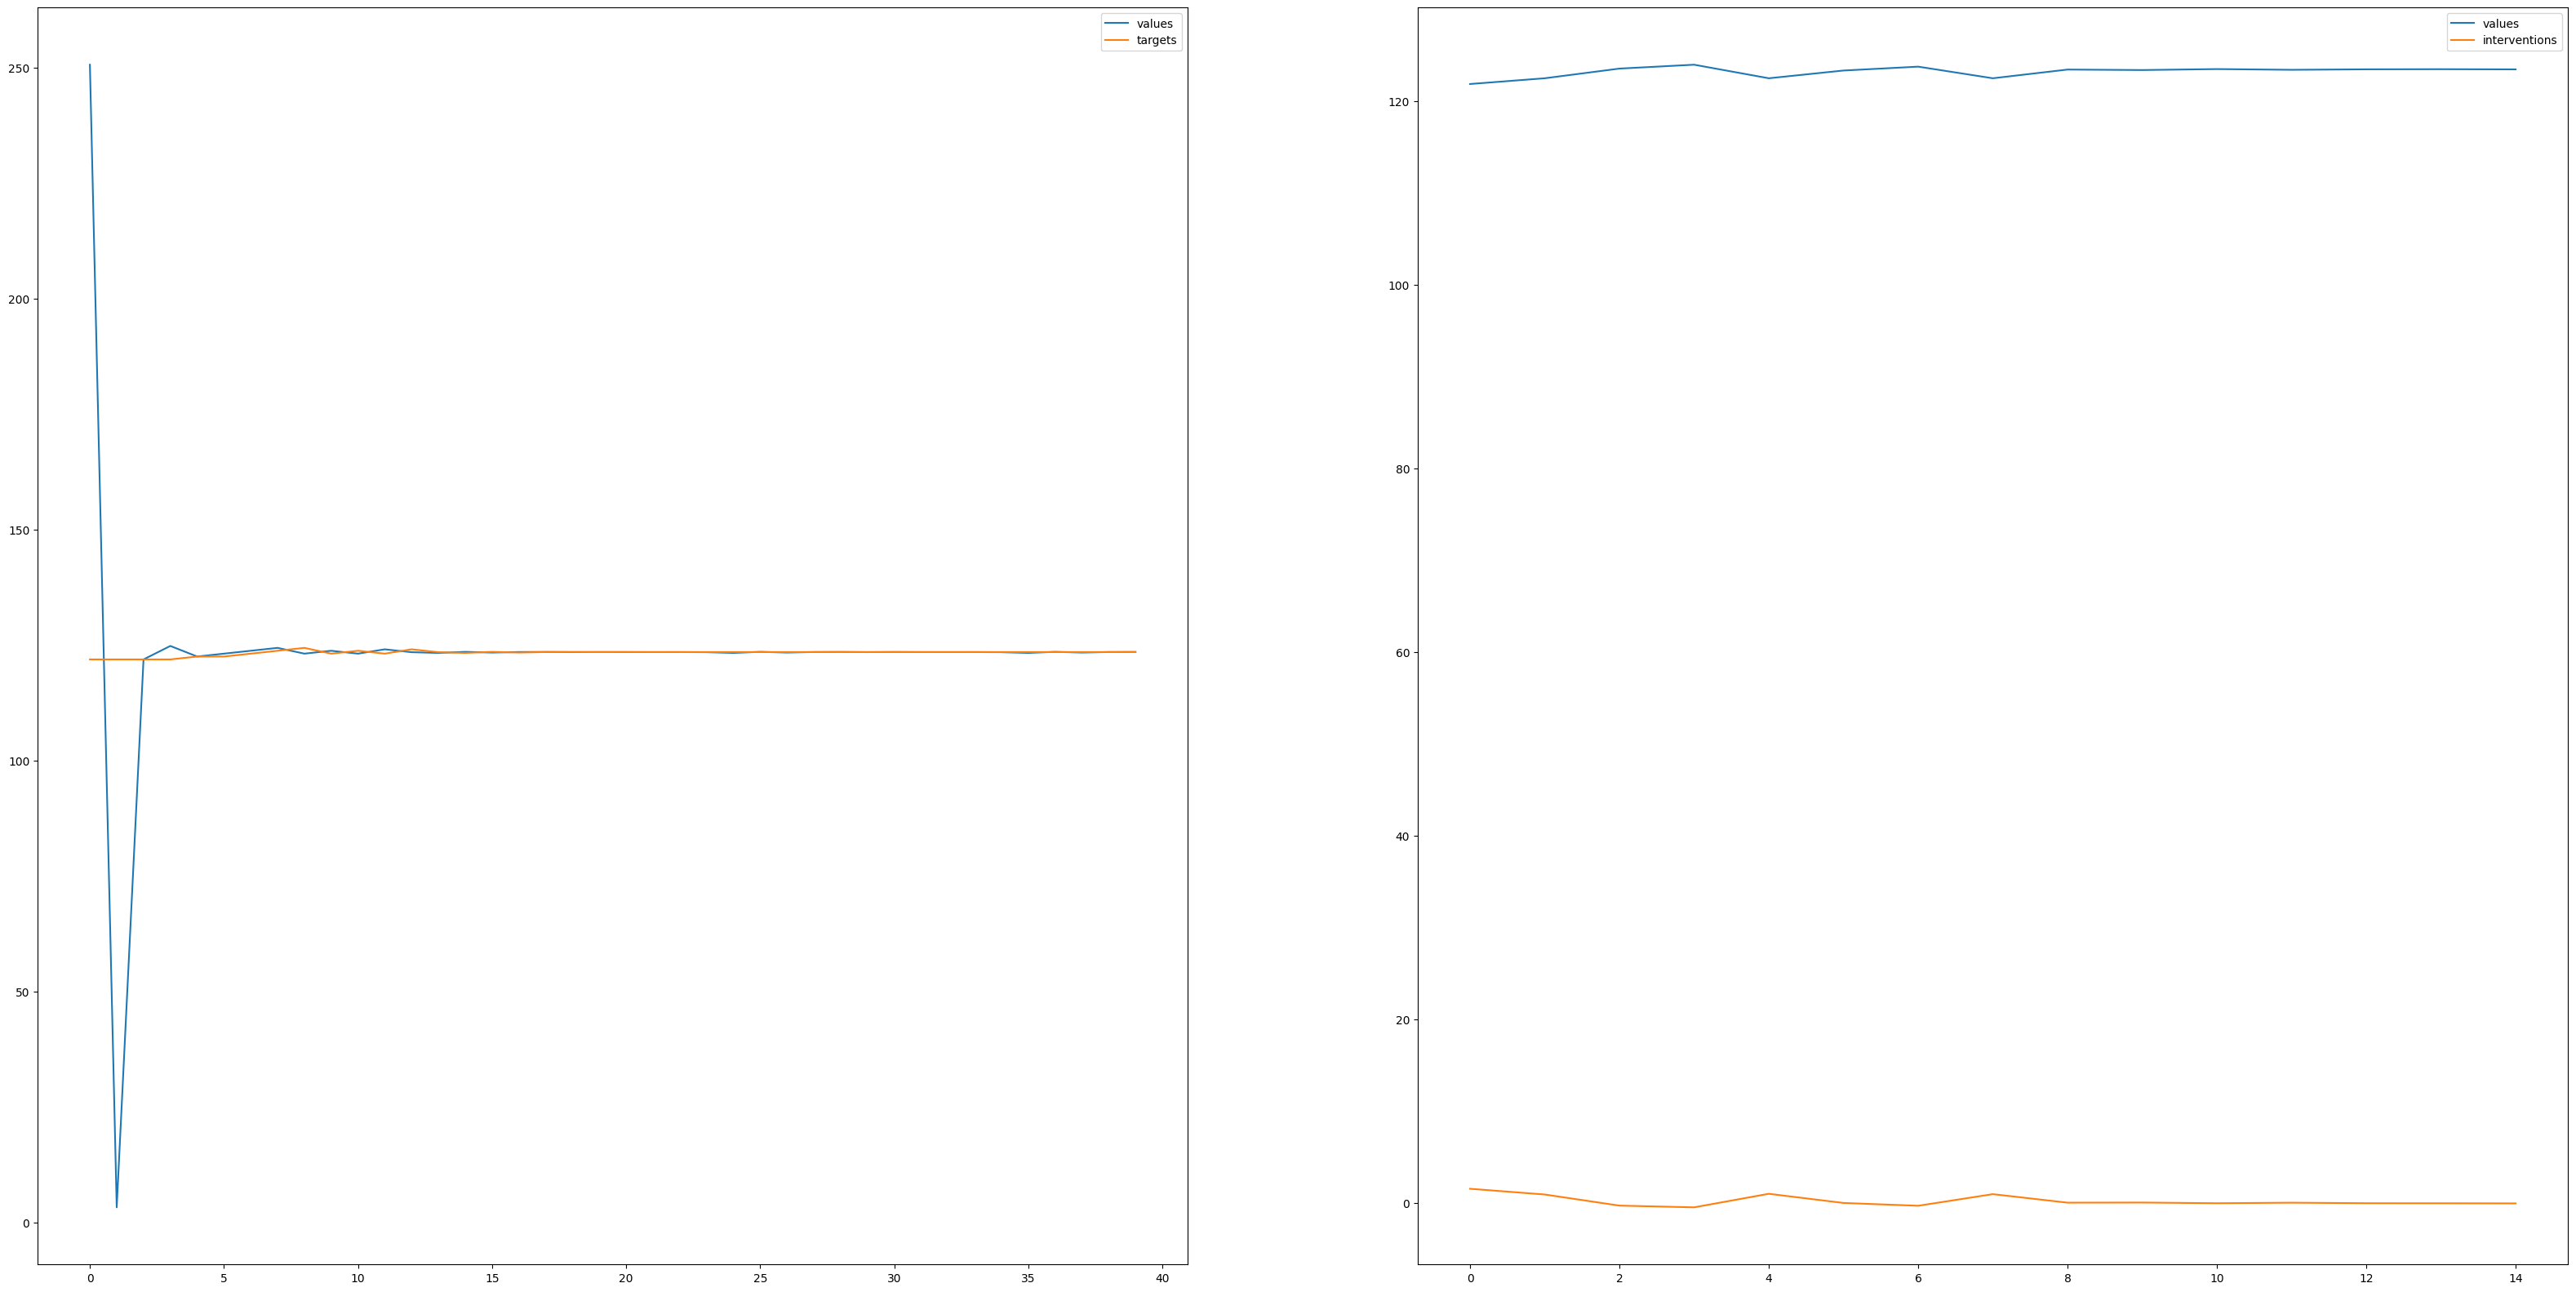

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.plot(n, stab.targets, label="targets")
ax1.legend();

n = np.arange(len(stab.interventor.values))
ax2.plot(n, stab.interventor.values, label="values")
ax2.plot(n, stab.interventor.interventions, label="interventions")
ax2.legend();

#### Test 3: Logistic

In [ ]:
g = LogisticFunction(4)
data = make_samples(1, 1000, g, g.max_val, noise=0.05, limit=False)
gConst = GraphConstructor(50, x=data[:-1], y=data[1:], min_val=0, max_val=1, automatic_padding="max", verbose=False)
G = gConst.create_graph()

In [ ]:
x = 0.3
max_int = 0.05
stab = Stabilizer(gConst, max_int)
all_vals = []
print("")
for i in range(15):
    int_val = stab.stabilize(x)
    all_vals.append(x+int_val)
    x = g(x+int_val)
    print("Intervention: ", int_val)
    print("Next value: ", x)
    print("")

Possible fixed points: [[0], [37]]
Choose point for stabilization: 37

Current node:  14
Shortest Path:  [37, 12, 46, 31, 40, 14]
Expected Path Length: 6
Intervention:  -0.016666666666666663
Next value:  0.8122222222222222

Current node:  40
Shortest Path:  [37, 12, 46, 31, 40]
Expected Path Length: 5
Intervention:  -0.009722222222222188
Next value:  0.6339750000000001

Current node:  31
Shortest Path:  [37, 12, 46, 31]
Expected Path Length: 4
Intervention:  0.0010249999999999426
Next value:  0.9271

Current node:  46
Shortest Path:  [37, 12, 46]
Expected Path Length: 3
Intervention:  0.00039999999999995595
Next value:  0.268975

Current node:  13
Best node:  12
Shortest Path:  [37, 12]
Expected Path Length: 2
Intervention:  -0.01897500000000002
Next value:  0.75

Current node:  37
Target reached using 6 steps
Intervention:  0.0
Next value:  0.75

Approached fixed point at 0.75
Current node:  37
Using previous path.
Intervention:  0.0
Next value:  0.75

Current node:  37
Using previous

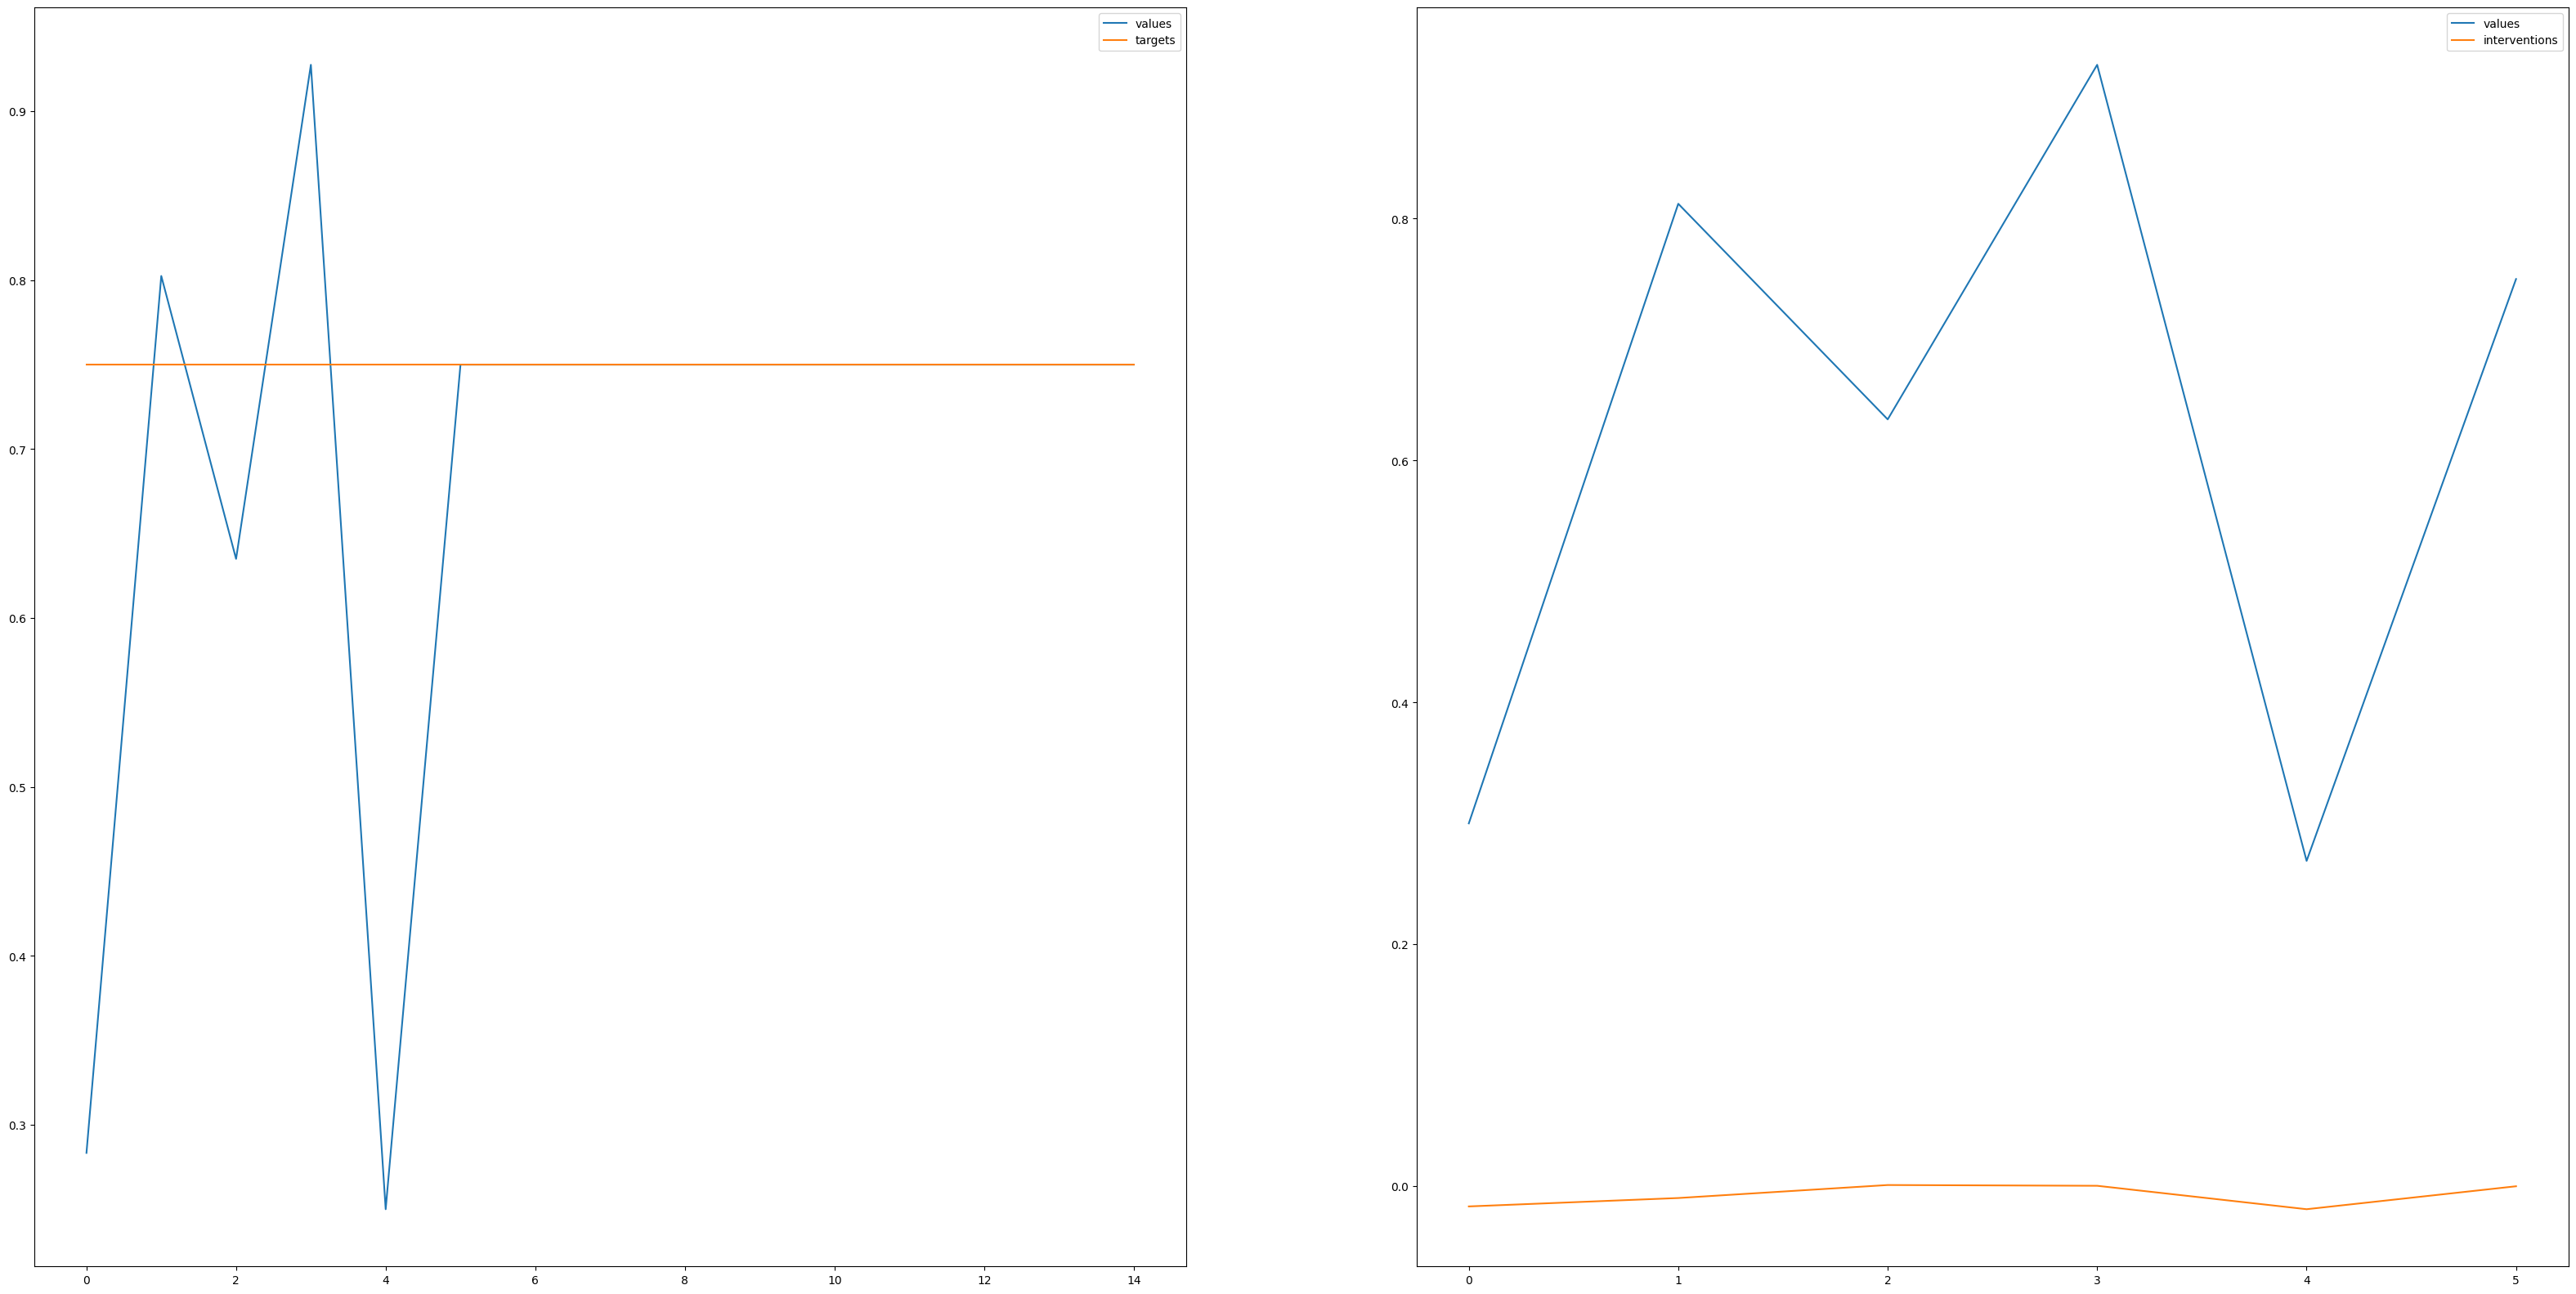

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))

n = np.arange(len(all_vals))
ax1.plot(n, all_vals, label="values")
ax1.plot(n, stab.targets, label="targets")
ax1.legend();

n = np.arange(len(stab.interventor.values))
ax2.plot(n, stab.interventor.values, label="values")
ax2.plot(n, stab.interventor.interventions, label="interventions")
ax2.legend();

#### Stabilizing Loops (WiP)

In [ ]:
class Looper:

  def __init__(self, gConst):
      self.gConst = gConst
      self.G = gConst.create_graph()
      self.loops = None
      self.loop_len = 0

      self.current_int = None


  def find_loops(self, loop_length=None, target=None, max_loop_length=5):
      """ Pass
      """
      if self.loops is None or self.loop_len < max_loop_length:
          self.loop_len = max_loop_length
          self.loops = list(nx.simple_cycles(self.G, max_loop_length))


      if not target is None:
          return self._find_loops_target(target)

      if not loop_length is None:
          return self._find_loops(loop_length)


  def _find_loops_target(self, target):
      node = self.gConst.get_node(target)
      lps = []
      print(node)
      for l in self.loops:
          if node in l:
              lps.append(l)

      return lps


  def _find_loops(self, loop_length):
      lps = []
      for l in self.loops:
          if len(l) == loop_length:
              lps.append(l)

      return lps


  def stabilize(self, s, loop, max_intervention):

      ints = []
      for i, t in enumerate(loop):
          t_val = (t + 0.5) * gConst.e
          ints.append(Interventor(gConst, t, max_intervention))

      self.intCycle = self._intCycler(ints)
      print("Stabilization ready!")


  def _intCycler(interventorList):
      i = 0
      l = len(interventorList)

      while True:
        yield interventorList[i]
        i = (i + 1) % l


  def intervene(self, x):
      if self.current_int is None or self.current_int.reached:
          self.current_int = next(self.intCycle)

      int_val = current_int.intervene(x)

      return int_val